## Suffix Tries

We will present some notes and implementations of Suffix Tries. We will work directly with so-called "compressed tries". What we are describing in these notes is often called a _generalized suffix trie_. 

This presentation is going to be somewhat sketchy. While the ideas are quite intuitive, the _devil_ (as they say) is in the _details_. The details are hard to describe fully and reading the code should give you a great idea. I sourced my presentation from two sources:

<div class="alert alert-block" style="background-color:lightcyan; border-color: black white black white">
    <ol>
        <li> Dan Gusfield's excellent book titled <i> Algorithms on Strings, Trees and Sequences </i>. 
         <li> Chapter on suffix tries available in the <i> Handbook of Data-Structures </i> by Dinesh P. Mehta and Sartaj Sahni (this is a much shorter presentation and also includes a related data structure called suffix arrays).
    </ol>
</div>


A suffix trie is a _trie data structure_ whose set of strings correspond to all the suffixes of a given string. As an example, consider the string _mamamia\$_ wherein "\$" represents the special termination character that only appears at the end of the string.
  - The suffixes are { _mamamia\$_, _amamamia\$_, _amamia\$_, _mamia\$_, _amia\$_, _mia\$_, _ia\$_, _a\$_, _\$_ }

The (generalized) suffix trie for the string "mamamia\$" is shown below:
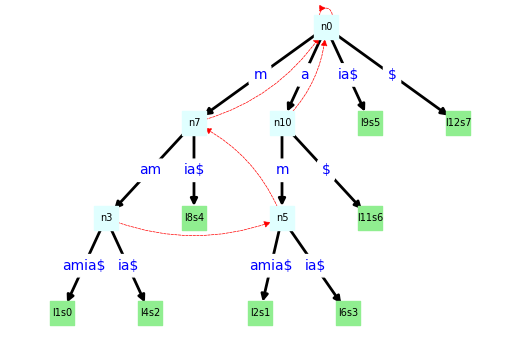</img>

For the time being ignore the red dashed edges (they are called suffix links and will be described subsequently). 

 - The internal nodes are shown in blue and leaves in green.
 
Each path from the root to leaf corrresponds to a suffix of the string (see set above)
and every suffix belongs to precisely one path. 

 - Each leaf is labeled "l\<i\>s\<j\>" for two numbers $i, j$ wherein $i$ denotes the 
 ID and $j$ denotes the starting position of the suffix that the leaf represents.

Note that the edges are "compressed": each edge is labeled by a substring of the 
original string rather than by a single character (in the case of a regular trie).
Also for every internal node, no two outgoing edges represent strings beginning with the same character. 

Therefore, for any string, there is either a unique path in the suffix trie starting from the root, or no path at all. Returning to the "mamamia$" example above, 
  - The string "amia" traces the path $$n0 \rightarrow n10 \rightarrow n5 \rightarrow ((\text{two characters offset into the edge from }\ n5\ \text{to}\ l6)) $$
  - On the other hand, there is no path corresponding to the string "anana" in the suffix trie. 
  
The key property of a suffix trie is the following:

<div class="alert alert-block" style="background-color:lightcyan; border-color: black white black white; border-style:dashed">
  Every path from root to leaf corresponds to a unique suffix of the string, and every suffix corresponds to a unique path from root to leaf.

</div>

Note that every node $n$ in the suffix trie has a unique path from the root to it and therefore has a unique string $s(n)$ that leads us from the root to that node. Note that $s(n) $ is empty if $n$ is the root node.

For the suffix trie in the "mamamia$" example above, we have the following values for $s(n)$ for various nodes $n$:

$$\begin{array}{rl}
\hline
n & s(n) \\ 
\hline 
n_0 & \text{<empty>} \\ 
n_7 & m \\ 
n_{10} & a \\ 
n_3 & mam \\ 
n_5 & am \\ 
\hline
\end{array}$$

### Suffix Links

Suffix links are a useful short cut between nodes in the trees. Let $n$ be an internal node where $s(n) = c \alpha$ where $c$ is a character and $\alpha$ is a substring. 
The suffix link is an edge of the form 
$n \rightarrow m$, such that $s(m) = \alpha$.

We will set the suffix link for the root to be itself by convention.

For the suffix trie in the "mamamia$" example above, the suffix links are shown as red dashed lines.

However, the key question is that why does a suffix link for a node need to point to another node. Could it not be possible that the suffix link for a node point to somewere in the middle of the string that labels an edge.

<div class="alert alert-block" style="background-color:lightcyan">
Let $n$ be an internal node such that $s(n) = c \alpha$. There must be an internal node $m$ in the suffix trie such that $s(m) = \alpha$.
</div>

**Proof:** Note that there must be a path in the tree corresponding to $\alpha$. We just need to show that the path cannot end up in a leaf node or in the middle of an edge. 
First off, since $n$ is an internal node of a compressed suffix trie, there are at least two suffixes in the original string of the form $c \alpha \beta_1$ and 
$c \alpha \beta_2$ for non-empty substrings $\beta_1, \beta_2$. Therefore, there are at least two suffixes $\alpha \beta_1$ and $\alpha \beta_2$, where $\beta_1, \beta_2$ differ at their very first position. Hence, the path starting from root corresponding to $\alpha$ cannot end in a leaf since there must be paths corresponding to $\alpha \beta_1$ and $\alpha \beta_2$. Also, it cannot end in the middle of an edge for the same reason since $\beta_1, \beta_2$ differ at the very first position. 

### Implementation

We will represent the root and internal nodes using the `SuffixTrieNode` class below.
It stores the following fields
  - `orig_str`: the original string.
  - `outgoing_edges`: a dictionary that maps characters to the outgoing edge that begins with the char.
  - `suffix_link`: the suffix link of the node, if it exists.
  - `depth`: the number of characters in the unique string that leads from the root to the node.
 - `id`: a unique number/id for the node. We reserve the id `0` for the root node.
 - `parent`: a pointer to the parent of the node. This is set to `None` for the root.


In [1]:
class SuffixTrieNode:
    
    def __init__(self, node_id, orig_str):
        self.orig_str = orig_str # a reference to the entire string
        self.outgoing_edges = {} # dictionary from chars to edges
        self.suffix_link = None  # suffix link : initially set to None
        self.id = node_id # Note: id == 0 is taken to be root for now.
        self.depth = 0 # automatically set the depth when node's parent is set
        self.parent = None # parent pointer
        
    def is_root(self):
        return self.id == 0
        
    def get_edge(self, char):
        if char in self.outgoing_edges:
            return self.outgoing_edges[char]
        else:
            return None
        
    def is_leaf(self):
        return False
    
    def add_suffix_link(self, node):
        self.suffix_link = node
        
    def add_outgoing_edge(self, new_edge):
        edge_init_char = new_edge.get_char_at(0)
        # ensure that an edge with the initial character does not exist
        assert edge_init_char not in self.outgoing_edges, f"Char {edge_init_char} already has an outgoing edge for node id:{self.id}"
        #ensure that the new_edge src matches self
        assert new_edge.src.id == self.id, f"Src node in outgoing edge id:{new_edge.src.id} does not match node id {self.id}"
        # add the new edge to the dictionary with the initial char as key
        self.outgoing_edges[edge_init_char] = new_edge
        # add a parent pointer from destination to the src of the new edge
        new_edge.dest.parent = new_edge.src # set the parent pointer of the new edges dest
        if not new_edge.is_leaf_edge(): # set the depth of the destination node for the edge
            new_edge.dest.depth = self.depth + new_edge.length()
       
        
    def find_edge_corresponding_to_child(self, child_node):
        # search among outgoing edges to see if there is one whose destination is the child node
        for (_, edge) in self.outgoing_edges.items():
            if edge.dest.id == child_node.id:
                return edge
        return None # no such edge found
    
        
    

We will use the `SuffixTrieLeaf` structure to represent leaves of the suffix trie.
Leaves will have a field `suffix_start_pos` that tells us where the suffix for the path from root to leaf starts in the original string.

Going back to the example suffix trie shown above for "mamamia$", we have labeled each leaf (shown in green) as `l<id>s<suffix_start_pos>` that gives us the starting position of the suffix that corresponds to a given leaf. 

In [2]:
class SuffixTrieLeaf:
    def __init__(self, node_id, orig_str, suffix_start_pos):
        self.orig_str = orig_str # the original string
        self.id  = node_id # the id of this node
        assert 0 <= suffix_start_pos < len(orig_str) 
        self.suffix_start_pos = suffix_start_pos # the starting pos for the suffix
        self.parent = None # parent pointer initially set to None
        
    def is_leaf(self):
        return True
    

The `SuffixTrieEdge` structure repreents an edge. An edge goes from `src` to `dest` nodes which can be internal nodes or `dest` can be a leaf.

Also the edge has two integers `lo` and `hi` that refer to positions in the string The edge is taken to represent the substring from positions `lo` to `hi` inclusive. Note that `hi=-1` represents the end of the string.

In [3]:
class SuffixTrieEdge:
    
    def __init__(self, orig_str, src_node, dest_node, lo, hi):
        assert 0 <= lo < len(orig_str) # lo must be a valid position in the original string
        # if destination node is a leaf then hi == -1 else hi != -1
        if dest_node.is_leaf():
            assert hi == -1 
        else:
            assert lo <= hi <= len(orig_str)
        assert not src_node.is_leaf() # src node cannot be a leaf.
        # edge represents str[lo]...str[hi] inclusive if hi != -1
        # or set[lo] ... str[end]
        self.orig_str = orig_str # set the orig_str field
        self.lo = lo # set lo/hi
        self.hi = hi 
        self.src = src_node # set src/dest
        self.dest = dest_node
        
    def is_leaf_edge(self):
        return self.hi == -1
    
    def length(self):
        if self.hi == -1:
            return -1
        else:
            return self.hi - self.lo + 1
    
    def get_char_at(self, offs):
        assert self.hi == -1 or offs + self.lo <= self.hi
        return self.orig_str[self.lo + offs]
    
    
    def get_sub_str(self, end=-1):
        if self.hi == -1:
            return self.orig_str[self.lo:end] if (end != -1) else self.orig_str[self.lo:]
        
        else:
            return self.orig_str[self.lo:self.hi+1]
        
        
    def reset_hi_and_dest(self, new_dest, new_hi):
        assert new_hi >= self.lo, f"Cannot replace hi value by {new_hi}"
        assert not new_dest.is_leaf(), "Cannot replace destination by a leaf node"
        self.hi = new_hi
        new_dest.parent = self.src
        new_dest.depth = self.src.depth + self.length()
        self.dest = new_dest
        
    
    
        
        

As a convenience, we will define a structure called an `TrieAddress` to refer to locations within a suffix trie. A trie address can be of two types:
  - A node (can be a root or internal node) of the trie, or
  - A triple `(node, edge, offset)` consisting of the 
     - internal/root `node`
     - An `edge` that must be an outgoing edge from the `node`
     - An `offset` that must be between 1 and  the edge length -1.


An address helps is point to a location in the trie that can be at a node or somewhere in the "middle" of an edge.

As an example `TrieAddress(n7, n7 -> n3, 1)` refers to a pointer that points to after the character `a` in the edge labled `am` from `n7` to `n3`.

Likewise `TrieAddress(n7, None, 0)` points to the internal node `n7`. If the suffix trie were actually a "full trie" with each edge labeled by a single character rather than a compressed trie (wherein each edge can be labeled by an arbitrary substring), a trie address would simply have pointed to a node of the full trie.


The trie address class implements three critical helper methods:
  - `address.travserse_next(c)` :  find the next address if we are currently located at `address` and then  encountered character `c`.
  - `address.compute_suffix()`: every address corresponds to a unique substring that takes us from the root node to that address. Suppose this string is of the form $c\alpha$, `compute_suffix` seeks to find the address corresponding to the string $\alpha$.
  - `address.create_new_edge_at`: If `address` points to an internal node, create a new edge with a new leaf node as destination corresponding to the suffix starting at position `i` of the original string. Else, if the address points to the middle of the string, "split" the edge and create a new internal edge/leaf.
  
  All of these routines are somewhat complicated since they need to deal with different cases. The comments will help you follow the logic of the code.
  Examples of each routine are provided based on the running example of "mamamia$".

In [72]:
class TrieAddress:
    
    def __init__(self,  node, edge=None, offs=0):
        assert 0 <= offs 
        self.node = node # set the node
        self.edge = edge # set the edge
        self.offs = offs # set the offset
        if self.edge != None:
            assert self.offs > 0
        else:
            assert self.offs == 0
    
    def traverse_next(self, c):
        """Function traverse_next: find the next address (if one exists) that 
           is obtained when we encounter character c. Return the new address if 
           one exists or else return None."""
        if self.edge == None: # Is the address pointing to an internal node?
            # Yes: address is just a pointer to an internal node/root.
            # check if the node has an outgoing edge corresponding to 'c'
            new_edge = self.node.get_edge(c) # try to get a new edge corresponding to character `c`.
            if new_edge == None:
                return None # No such edge, then return None
            else: # new_edge != None
                assert new_edge.get_char_at(0) == c # got an edge. Check that we got the right one.
                if new_edge.is_leaf_edge() or new_edge.length() > 1: # if new edge is a leaf edge, or its length is more than 2
                    return TrieAddress( self.node, new_edge,  1 ) # return an address with an offset of 1 into the new edge
                else:
                    new_node = new_edge.dest # new edge is not a leaf and must have length exactly one
                    return TrieAddress( new_node, None, 0) # the address must therefore be the destination.
        else: # self.edge != None
            # No: address is a pointer self.offs past self.node along self.edge
            edge = self.edge 
            if edge.lo + self.offs < len(edge.orig_str) and edge.get_char_at(self.offs) == c:# if the next char is a `c`
                if edge.is_leaf_edge() or self.offs < edge.length() -1 : # is the edge a leaf edge or do we have one more char in the edge?
                    return TrieAddress(self.node, self.edge, self.offs+1) # return a new address that is just one further offset along same edge
                else:
                    dest_node = edge.dest # we reaches the destination node
                    return TrieAddress( dest_node, None, 0) # return the new address
            else: # next char is not a `c`
                return None # no next address
            
    def compute_suffix(self, debug=False):
        # to compute a suffix, follow the suffix link from the source node
        #                      to get to a new source node.
        #                     next, fetch the appropriate edge 
        #                     finally, move offset distance into the edge.
        node = self.node # unpack
        edge = self.edge 
        offs = self.offs 
        if node.id == 0 and offs <= 1: # If we are at the very root, the suffix is the same.
                return TrieAddress(node, None, 0) # let's keep the suffix the same
        if node.id == 0: # if we are the the root, the suffix node is the root
            s_node = node
        else:
            s_node = node.suffix_link # otherwise, follow the suffix link.
            assert s_node != None # assert that the suffix link should exist
        
        if edge == None: # if the address points right to a node, 
            return TrieAddress(s_node, None, offs) # the suffix address points right to the suffix node.
        
        if node.id == 0: # Are we are at the root.
            c = edge.get_char_at(1) # compute the char c at position 1 of the edge.
            s_edge = node.get_edge(c) # get the outgoing edge for that character c
            assert s_edge != None, f"No edge for char {c} at node {node.id}" # this edge should exist
            offs = offs - 1 # suffix is offs -1 length along s_edge
            fwd = 1 # set the fwd pointer to 1 to indicate that we have moved one step fwd
            if debug:
                print(f"Debug: Looking for {offs} past {s_edge.src.id, s_edge.dest.id}")
        else:
            c = edge.get_char_at(0) # get the initial char at the edge
            s_edge = s_node.get_edge(c) # get the corresponding edge at the suffix link
            fwd = 0
            assert s_edge != None, f"No edge for char {c} at node {s_node.id}"
            if debug:
                print(f"Debug: Looking for {offs} past {s_edge.src.id, s_edge.dest.id}")

        assert s_edge != None # assert that the edge should exist
         # Now we have to find the location that is offs steps away from s_node 
         # along s_edge. 
        if s_edge.is_leaf_edge() or offs < s_edge.length(): 
            # if the edge is leaf or the offset is less than the length
            return TrieAddress(s_node, s_edge, offs) # we found the required suffix address along s_edge itself
        else:
            new_offs = offs # otherwise, move offset distance away from edge
            # we may have to move across multiple nodes/edges to find the location 
            # that is offs away from node s_node.
            while (not s_edge.is_leaf_edge()) and new_offs >= s_edge.length():
                new_offs = new_offs - s_edge.length() # move forward edge length from s
                fwd = fwd + s_edge.length()
                s_node = s_edge.dest # get the destination node
                if new_offs > 0:
                    c = edge.get_char_at(fwd) # get the edge corresponding to the character
                    s_edge = s_node.get_edge(c)
                    assert s_edge != None
                else:
                    break
            if new_offs > 0:
                return TrieAddress(s_node, s_edge, new_offs)
            else:
                return TrieAddress(s_node, None, 0)

    def create_new_edge_at(self, orig_str, i, node_id):
        """Create a new leaf edge in the suffix trie by 
           inserting the char at orig_str[i]. """
        assert i >= 0 and i < len(orig_str) # i better be a valid index into orig_str
        c = orig_str[i]  # fetch the char
        node = self.node # unpack 
        edge = self.edge 
        offs = self.offs
        if edge == None: # if the current address points to an internal node
            assert offs == 0
            assert node.get_edge(orig_str[i]) == None, f"Node {node.id} already has outgoing edge for {orig_str[i]}"
            new_leaf = SuffixTrieLeaf(node_id, orig_str, i - node.depth) # create a new leaf node to be the destination
            new_edge = SuffixTrieEdge(orig_str, node, new_leaf, i, -1) # create a leaf edge with 
            node.add_outgoing_edge(new_edge) # add it to the node pointed by the current address
            return (node, new_leaf, False) # return the node at which insertion happend, the new leaf and whether or not a new internal node was created
        else:
            assert edge.get_char_at(offs) != c, f'{edge.get_char_at(offs)}, {c}' # if the next char is c, we should not be calling this function
            # split edge into two
            node1 = SuffixTrieNode(node_id, orig_str) # create a new node       
            src_node = edge.src 
            dest_node = edge.dest 
            lo = edge.lo
            hi = edge.hi
            # modify the current edge to make node1 its destination and the 
            # value of hi to be lo. +offs -1 
            edge.reset_hi_and_dest(node1, lo+offs-1)
            # create two new edges 
            # first one consists of the remaining part of edge
            new_edge_1 = SuffixTrieEdge(orig_str, node1, dest_node, lo+offs, hi)
            node1.add_outgoing_edge(new_edge_1)
            suffix_start_pos = i - node1.depth
            # create a new leaf node 
            new_leaf = SuffixTrieLeaf(node_id+1, orig_str, suffix_start_pos)
            # create a new leaf edge 
            new_edge_2 = SuffixTrieEdge(orig_str, node1, new_leaf, i, -1)
            node1.add_outgoing_edge(new_edge_2)
            return (node1, new_leaf, True) # return newly created internal node and new leaf, True indicates that the internal node we are returning is newly created
            
    def is_at_root(self):
        return self.node.id == 0 and self.offs == 0
            
    def compute_depth(self):
        if self.edge == None:
            return self.node.depth
        else:
            return self.node.depth + self.offs 
    
    def __str__(self):
        edge = self.edge
        return f'{self.node.id}, {(edge.src.id, edge.dest.id) if edge != None else None}, {self.offs}'
                

Below, we have a very useful routine to draw a suffix trie using networkx package in Python.

In [5]:
import networkx as nx
from matplotlib import pyplot as plt

def draw_networkx_graph(root, end=-1, highlight_addr=None, filename=None):
    worklist = [root]
    node_labels={}
    edge_str_label = {}
    suffix_links = [] 
    leaf_nodes = []
    internal_nodes = []
    G = nx.DiGraph()
    while len(worklist) > 0:
        node = worklist.pop()
        G.add_node(node.id)
        if node.is_leaf():
            leaf_nodes.append(node.id)
            node_labels[node.id]= "l"+str(node.id) + "s"+str(node.suffix_start_pos)
            continue
        else:
            internal_nodes.append(node.id)
            node_labels[node.id]= "n"+str(node.id)
        if node.suffix_link != None:
            suffix_links.append((node.id, node.suffix_link.id))
        for (c, edge) in node.outgoing_edges.items():
            (u, v) = (edge.src.id, edge.dest.id)
            G.add_edge(u, v)
            s = edge.get_sub_str(end)
            edge_str_label[(u,v)] = s
            worklist.append(edge.dest)            
    pos = nx.nx_agraph.graphviz_layout(G, prog="dot")  # positions for all nodes
    fig, ax = plt.subplots()
    fig.set_tight_layout(True)
    nx.draw_networkx_nodes(G, pos=pos, nodelist=internal_nodes,  node_shape="s", node_color="lightcyan")
    nx.draw_networkx_nodes(G, pos=pos, nodelist=leaf_nodes, node_shape="s", node_color="lightgreen")
    nx.draw_networkx_edges(G, pos=pos,width=2.0)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=7, font_color='k')
    #nx.draw_networkx_edge_labels(G, pos,edge_labels=edge_char_label, font_color='red')
    nx.draw_networkx_edge_labels(G, pos,edge_labels=edge_str_label, font_color='blue', rotate=False)
    nx.draw_networkx_edges(G, pos, width=0.5, edgelist=suffix_links, style='dashed', edge_color='r', connectionstyle='arc3,rad=0.2')
    if highlight_addr != None:
        node = highlight_addr.node 
        edge = highlight_addr.edge
        offs = highlight_addr.offs
        nx.draw_networkx_nodes(G, pos=pos, nodelist=[node.id],  node_shape="s", node_color="yellow")

        if edge != None:
            nx.draw_networkx_edges(G, edgelist=[(edge.src.id, edge.dest.id)], edge_color='b', width=2, pos=pos)
            c = edge.get_char_at(0)
            txt = f'{offs}'
            x0,y0 = pos[node.id]
            x1,y1 = pos[edge.dest.id]
            (x, y) = ((3*x0+x1)/4, (3*y0+y1)/4)
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
            plt.text(x-0.5, y+0.5, s=txt,  fontsize=8, bbox=props,horizontalalignment='center')
        
    ax = plt.gca()
    ax.margins(0.20)
    plt.axis("off")
    if filename != None:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()
    
        

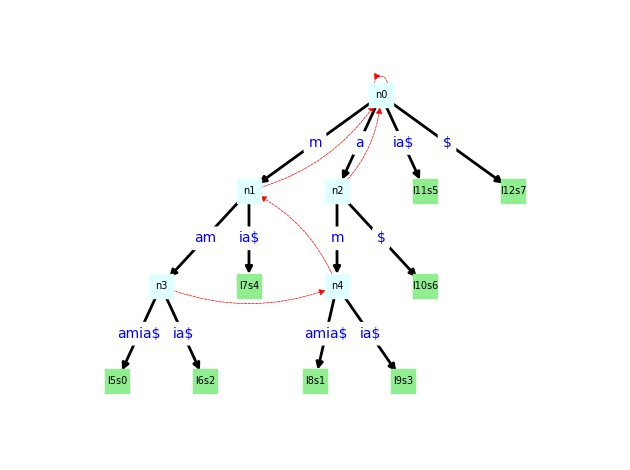

In [6]:
## Let's manually construct a test suffix trie for "mamamia$"
orig_str = "mamamia$"

n3 = SuffixTrieNode(3, orig_str)
l31 = SuffixTrieLeaf(5, orig_str, 0)
l32 = SuffixTrieLeaf(6, orig_str, 2)
e31 = SuffixTrieEdge(orig_str, n3, l31, 3, -1)
e32 = SuffixTrieEdge(orig_str, n3, l32, 5, -1)
n3.add_outgoing_edge(e31)
n3.add_outgoing_edge(e32)

n4 = SuffixTrieNode(4, orig_str)

l41 = SuffixTrieLeaf(8, orig_str, 1)
l42 = SuffixTrieLeaf(9, orig_str, 3)
e41 = SuffixTrieEdge(orig_str, n4, l41, 3, -1)
e42 = SuffixTrieEdge(orig_str, n4, l42, 5, -1)
n4.add_outgoing_edge(e41)
n4.add_outgoing_edge(e42)

n1 = SuffixTrieNode(1, orig_str)
l11 = SuffixTrieLeaf(7, orig_str, 4)
e11 = SuffixTrieEdge(orig_str, n1, n3, 1, 2)
e12 = SuffixTrieEdge(orig_str, n1, l11, 5, -1)
n1.add_outgoing_edge(e11)
n1.add_outgoing_edge(e12)


n2 = SuffixTrieNode(2, orig_str)
l21 = SuffixTrieLeaf(10, orig_str, 6)
e21 = SuffixTrieEdge(orig_str, n2, n4, 2, 2)
e22 = SuffixTrieEdge(orig_str, n2, l21, 7, -1)
n2.add_outgoing_edge(e21)
n2.add_outgoing_edge(e22)

root = SuffixTrieNode(0, orig_str)
l11 = SuffixTrieLeaf(11, orig_str, 5)
l12 = SuffixTrieLeaf(12, orig_str, 7)
e01 = SuffixTrieEdge(orig_str, root, n1, 0, 0 )
e02 = SuffixTrieEdge(orig_str, root, n2, 1, 1)
e03 = SuffixTrieEdge(orig_str, root, l11, 5, -1)
e04 = SuffixTrieEdge(orig_str, root, l12, 7,-1)
root.add_outgoing_edge(e01)
root.add_outgoing_edge(e02)
root.add_outgoing_edge(e03)
root.add_outgoing_edge(e04)
root.add_suffix_link(root)
n1.add_suffix_link(root)
n2.add_suffix_link(root)
n3.add_suffix_link(n4)
n4.add_suffix_link(n1)

draw_networkx_graph(root)

We will now show the use of some of the methods created above. We will create an address initially `(root, None, 0)` and call various methods on it.

In [7]:
addr0 = TrieAddress(root) # address pointing to the root.
addr1 = addr0.traverse_next('m') # should now point to node n1
print(f"addr1 = ({addr1})")
addr2 = addr1.traverse_next('i') # should now point to n1, along edge (n1 -> l7), offset 1
print(f"addr2 = ({addr2})")
addr3 = addr2.compute_suffix() # should now point to n0, along edge (n0 -> l11), offset = 1
print(f"addr3 = {addr3}")
addr4 = addr3.compute_suffix() # should now point just to n0
print(f"addr4 = {addr4}")

addr1 = (1, None, 0)
addr2 = (1, (1, 7), 1)
addr3 = 0, (0, 11), 1
addr4 = 0, None, 0


## Creating a Suffix Trie : Inefficient Algorithm

We will now have a simple but inefficient algorithm for creating a suffix trie. The idea is to go through each suffix one by one and insert it into the tree starting from the empty tree.


In [8]:
def make_suffix_trie_simple(orig_str): 
    # Insert the suffix starting from orig_str position j into the trie.
    root = SuffixTrieNode(0, orig_str)
    n = len(orig_str)
    node_list = [root]
    for j in range(n):
        addr = TrieAddress(root) # initialize the address to 0
        for i in range(j, n):
            # try traversing one step more from the current address with char orig_str[i]
            addr1 = addr.traverse_next(orig_str[i])
            if addr1 == None:
                # here is where we need to insert.
                (next_node, leaf_node, newly_created) = addr.create_new_edge_at(orig_str, i, len(node_list) )
                node_list.append(leaf_node)
                if newly_created:
                    node_list.append(next_node)
                break 
            else:
                addr = addr1
    return root 

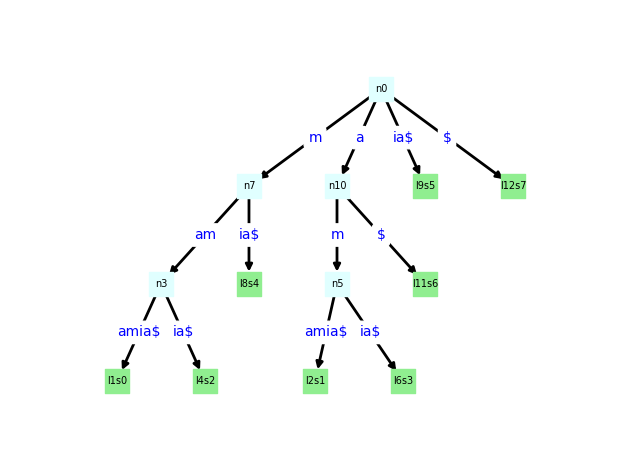

In [9]:
root = make_suffix_trie_simple("mamamia$")
draw_networkx_graph(root)

Notice that the suffix links are missing. We can however create suffix links after the fact and do so efficiently. We will explore this as part of our problem set.

The overall complexity is $O(m^2)$ for a string of length $m$. We have $m$ suffixes to insert and the $j^{th}$ suffix is of size $m-j$. Total time is proportional to $\sum_{j=0}^m (m-j) = O(m^2)$.

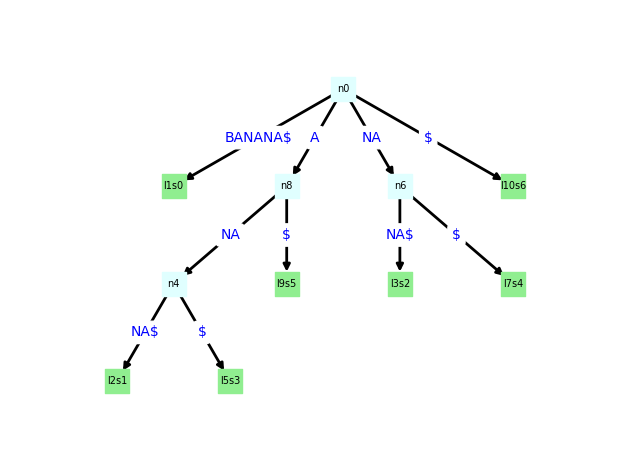

In [57]:
root = make_suffix_trie_simple("BANANA$")
draw_networkx_graph(root, filename="assignment4-fig1.png")

## Ukkonen's Algorithm

We will now discuss an $O(m)$ algorithm for constructing suffix tries. This is in fact the most efficient algorithm possible. It is somewhat involved and depends on many improvements to a rather inefficient baseline algorithm that will serve as our starting point.


### Baseline Algorithm

Baseline algorithm builds a sequence of implicit suffix tries $T_0, \ldots, T_m$ wherein  $T_0$ is the empty trie, $T_1$ is the trie for $s[0]$ and in general $T_i$ is an (implicit) suffix trie for the substring $s[0], \ldots, s[i-1]$. We extend $T_i$ to $T_{i+1}$ by extending it with the character $s[i]$.  This is called phase \# $i$ of the algorithm.

- $T_0$ is the empty tree with just a single root node.
- for i = 0 to m-1
  - Extend $T_i$ to $T_{i+1}$ by inserting character $s[i]$ at the end.

The _extension_ from $T_{i}$ to $T_{i+1}$ happens in $i$ extension steps each step 
$j$ adding $s[i]$ to the end of the suffix $s[j] \ldots s[i-1]$.


The overall baseline algorithm is 
  

- $T_0$ is the empty tree with just a single root node.
- for i = 0 to m-1
  - for j = 0 to i
     - Find location in tree corresponding to substring $s[j], \ldots, s[i-1]$ (root node if this is empty substring).
     - Insert $s[i]$ at the location based on Rules 1 - 3 described below.
     
The three rules for inserting $c=s[i]$ are as follows:
 - Rule # 1: if the location in tree is a leaf node then, we add the character $c$ to the end of the unique edge from the node's parent to itself.
 - Rule # 2: if the location in tree is an internal node or an internal node + an offset along an edge:
   - If the location is an internal node that does not have an outgoing edge corresponding to the character $c$, then add such an outgoing leaf edge to a new leaf node. This edge is labeled with character $c$.
   - If the location is an internal node + an edge and an offset along that edge and the next character is not $c$, then split the edge at the offset by creating a new internal node and two new edges. One of the new edges will be labeled by the character $c$.
   
 - Rule # 3: if the location in tree is an internal node or an internal node + an offset along an edge:
   - If the location is an internal node, but has an outgoing edge corresponding to the character $c$, then do nothing.
   - If the location is an internal node + an edge and an offset along that edge and the next character is $c$, then do nothing.
   
### Examples

Suppose we are building a trie for the string `mamamia$` and we have built $T_4$ which is a trie for the substring `mama`.
<img src="attachment:mamamia$.3.png" width="60%"></img>

Ignore the annotation `2` on the blue edge for now. Suppose we wanted to extend it to $T_5$ which would be the trie for the substring `mamam`. We have to extend $T_4$ by attaching the character `m` at the end. We have to consider 5 extentions:
  - E1: `mama` -> `mamam` (rule 1)
  - E2: `ama` -> `amam` (rule 1)
  - E3: `ma` -> `mam` (rule 2)
  - E4: `a` -> `am` (rule 3)
  - E5: insert `m` at root (rule 3)

Note that E1, E2 follow Rule # 1 above since they extend an edge to a leaf by one characted. 

E3, E4 and E5 follow Rule # 3 since the corresponding substrings `mam`, `am` and `m` already exist in the tree.

The result is shown below.
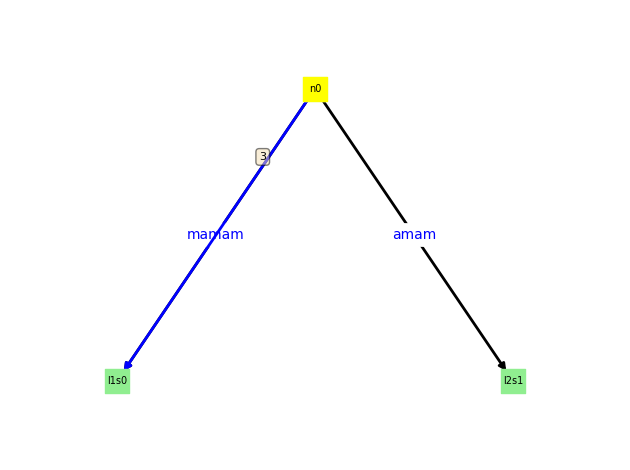 </img>

Next, we wish to insert the character "i" to go from $T_5$ to $T_6$. We have to consider 6 extensions:
  - E1: `mamam` -> `mamami` (rule 1)
  - E2: `amam` -> `amami` (rule 1)
  - E3: `mam` -> `mami` (rule 2)
  - E4: `am` -> `ami` (rule 2)
  - E5: `m` -> `mi` (rule 2)
  - E6:  insert `i` at root (rule 2)
 
 Note that E3 follows rule # 2. The reason is that there is an edge corresponding to `mam` in the tree. But the next character in this edge has to be an `a` whereas we are interested in inserting a character `i`. As a result, the edge is split and a new node 
  $n3$ is added. Similarly, the extensions E4, E5 and E6 follow rule # 2 as well.

E4 will lead to the creation of a new node $n5$, E5 to a new node $n7$ and E6 to a new leaf node $l9$.

The result is as follows:
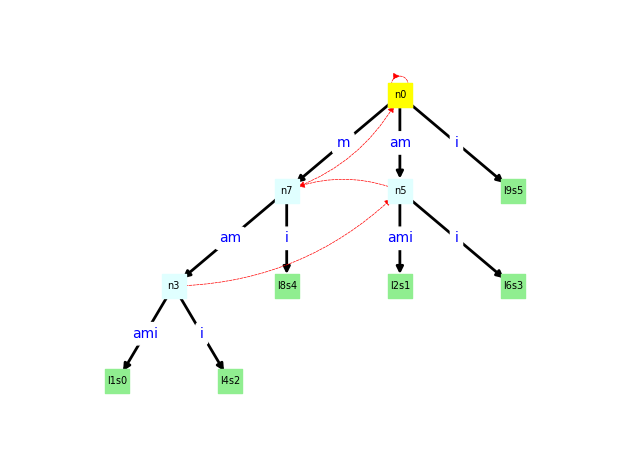</img>

Note that we can add in suffix links in this process. Successive internal nodes (cannot be leaf nodes) that are _freshly created_ as a result of successive applications of rule 2 will be suffix linked.  But the chain of suffix links will end at the root node. We have to be careful not to add suffix links to leaf nodes in this process.


## Making it Faster

As such, the baseline algorithm has complexity $O(m^3)$ and makes things worse upon the first sight.  We will now work on making this process faster.
  - First of all, we will avoid doing rule # 1 which extends the leaf edges by one more character. We will internally label leaf edges with a special upper bound `-1` that is a place holder for the position $i$ for tree $T_i$. Automatically considering a new $i= i+1$ cases all appplications of rule # 1 to happen.
  
 - Next, we can always terminate a phase when we get to rule # 3. Suppose a path for a string of the form $\alpha c$ for substring $\alpha$ and char $c$ already exists in the suffix trie so far, then it will exit for all suffixes of $\alpha c$ and the phase can be terminated the moment we encounter rule # 3. 
   - Interestingly the first time we hit rule # 3 in a phase, we can just stop and remember where we are in the trie. In the next phase, we can simply start from what ever location we were at the end of the previous phase when rule # 3 first applied.
   
We are now ready to develop Ukkonen's algorithm.

The main idea in Ukkonen's algorithm is to build the trie in phases $T_0$, $T_1$, $\ldots$, $T_m$ as before but to optimize the construction so that the total time spent in $O(m)$ across all the phases. 

 - Ukkonen's algorithm will never consider rule # 1 since we will have leaf edges maintain an implicit `hi` index of `-1` that denotes the end of the substring so far. At each phase, we move the end of the string by one position to the right implicitly. Therefore, we do not need to keep visiting these edges and adding the end character explicitly. 
 - Ukkonen's algorithm will terminate a phase as soon as rule # 3 applies for the first time. This is achieved by storing an `address` for the trie constructed thus far. This address indicates where rule 3 would have applied for the first time for the previous phase. 
   - This address is initialized to point to the root node at the very start.
   
The only rule that causes the algorithm to do more than constant amount of work at each phase is rule # 2. This successively either splits an edge into two causing the creation of a new internal node and edge, or inserts a leaf edge at an already existing internal node.

Let us illustrate the working on the string "BANANA$".

#### Phase 0

We insert the character `B` into the empty trie. Rule # 2 applies.

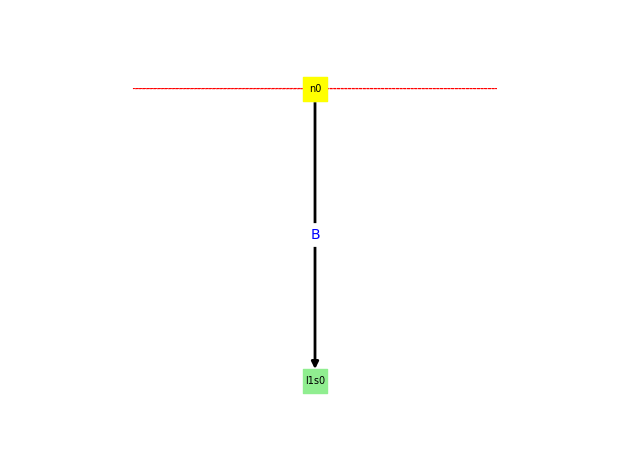</img>

At the end the  address points to the root.

### Phase 1

We insert the character `A` into the trie at the end of previous phase. The extension `B` -> `BA` is carried out implicitly by applying rule # 1. We simply add a new leaf edge with the character `A` at the root.

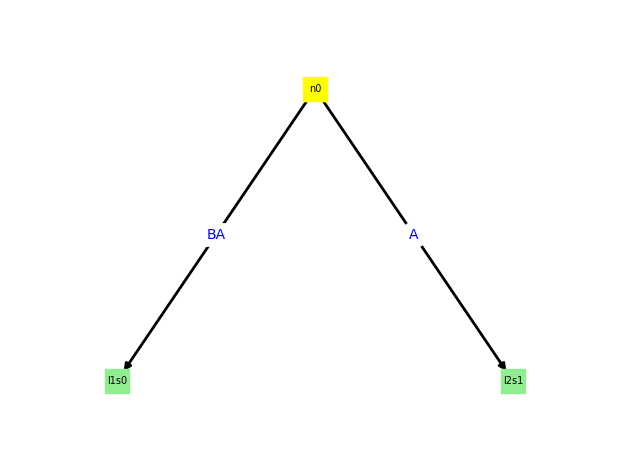</img>

The address pointer continues to point to the root.

### Phase 2

We insert the character `N` at the end of the previous phase. The extensions `BA` -> `BAN` and `A` -> `AN` are implicitly carried out (the algorithm does not need to do anything for these). It simply inserts `N` at the current address which is the root. The current address remains the root.
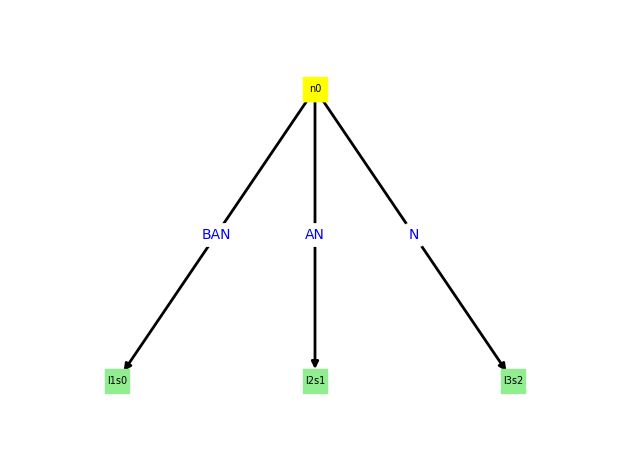</img>

### Phase 3

We now insert the character `A` at the end. Current address is at the root. There are three extensions that involve rule # 1 but these are not considered. We simply seek to insert the character `A` at the root but an edge labeled `AN` already exists. We simply note that rule # 3 would apply and move one position along that edge. The new address points to an offset of `1` into the edge `AN` outgoing form `n0`. The figure below illustrates this.

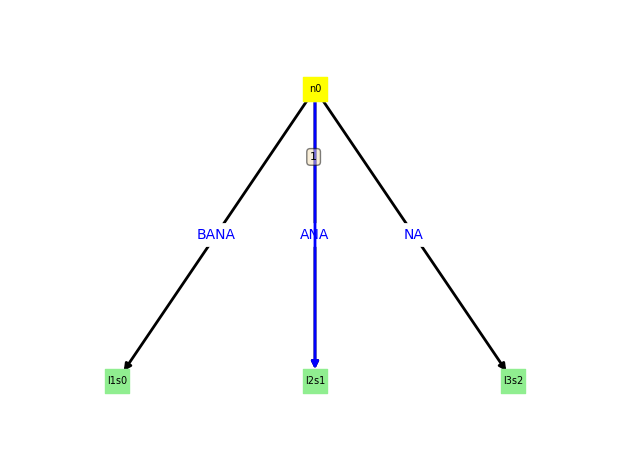</img>

### Phase 4
We will now insert the character `N` at the end.
Since the previous phase ended with an application of rule 3 at the address `(n0, n0 -> l2, 1)` in the trie, we will simply seek to insert the character `N` there. We see that rule 3 applies once again. The address is simply updated to `(n0, n0 -> l2, 2)` and we stop.

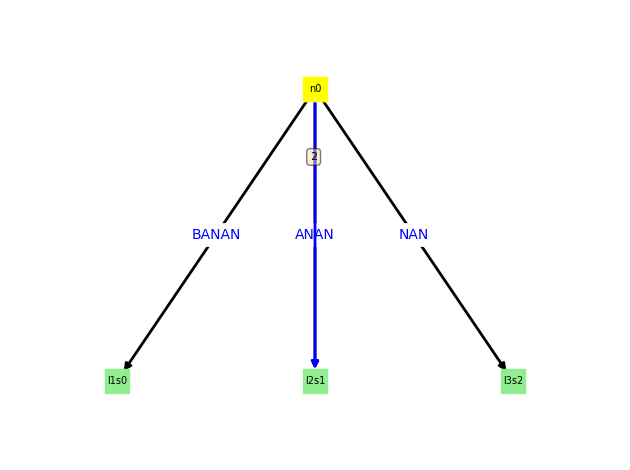</img>

### Phase 5

We will insert the character `A` at the end. Since the previous phase ended with an application of rule 3 at the address `(n0, n0 -> l2, 2)` in the trie, we will simply seek to insert the character `A` there. We see that rule 3 applies once again. The address is simply updated to `(n0, n0 -> l2, 3)` and we stop.

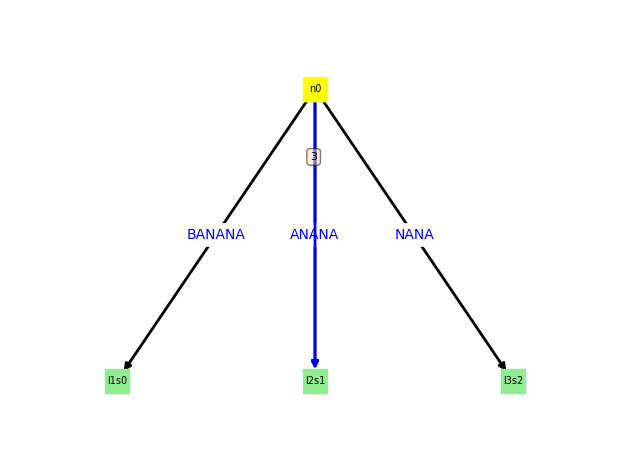</img>

### Phase 6

We will seek to insert the `$` character at the end. The previous phase ended at `(n0, n0 -> l2, 3)`. We seek to insert the `$` character there. However, note that there is no such character there. Rule 2 applies and we need to split the edge.
  - We split the edge $n0 \rightarrow l2$ and insert a new internal node $n4$ there.
  - Next, we follow the suffix link for our current address and try insert `$` there.
     - The suffix link leads us to the edge $n0 \rightarrow l3$ with an offset of $2$. 
     - We insert `$` there. This leads to a new internal node $n6$. We add a suffix link from $n4$ to $n6$.
     - address becomes $(n0, n0 \rightarrow l3, 2)$
  - Next we follow the suffix link from our current address and try to insert `$` there.
      - The suffix link leads us back to the edge $n0 \rightarrow n4$ with an offset of $1$.
      - We try to insert `$` there. This leads to the creation of a new insternal node $n8$. 
      - We add a suffix link from $n6$ to $n8$.
      - address now becomes $(n0, 0)$.
  - We add a suffix link from $n8$ to the root. We insert `$` at the root, leading to a new leaf node and edge.
  
  
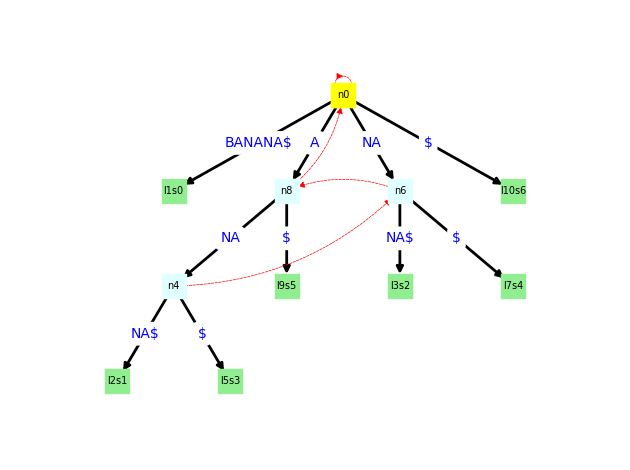</img> 

The overall algorithm code is below. This is a complicated algorithm (since there are a few special cases to take care of). Hopefully, the description above gives you an idea of how the algorithm works. We encourage you to read the code and comments carefully.

In [12]:
# Implementation of Ukkonen's algorithm
def construct_suffix_trie(orig_str, debug=False):
    root = SuffixTrieNode(0, orig_str) # create a root node with id = 0
    root.add_suffix_link(root) # make the root suffix link to itself
    node_list= [root] # maintain a list of all nodes for our bookkeeping
    addr = TrieAddress(root, None, 0) # initialize the address to point to the root
    n = len(orig_str)
    for i in range(n): # go through each position in the original string
        # We will now work on phase number i of the algorithm
        c = orig_str[i] 
        if debug:
            print(f"Phase # {i}: inserting {c}")
        node = None # initialize pointers to node and new_node to None
        new_node = None # these pointers will help us with the adding of suffix links for newly created nodes later
        dest = addr.traverse_next(c) # try to move from the current address to a new address given the character `c`.
        if dest != None:
            addr = dest # dest exists, we simply update addr to that destination and continue
        else: # no such destination exists. Rule # 2 applies and we have to create new internal nodes
            while dest == None and not addr.is_at_root(): # while the current addr does not have a destination for next character c, and it is not at the root
                if debug:
                    print(f"Creating new node with char {orig_str[i]} at {addr}")
                # create a new node and a new leaf at the current address
                (new_node, new_leaf, newly_created) = addr.create_new_edge_at(orig_str, i, len(node_list))
                if debug:
                    print(f"Created new node: {new_node.id}")
                
                if node != None and not node.is_root():
                    node.add_suffix_link(new_node) # add a suffix link from the previously created node to the new node
                    if debug:
                        print(f"D1: Adding Suffix Link:{node.id} ---> {new_node.id}")
                if newly_created:
                    node_list.append(new_node) # if it is freshly created then add it to the list of nodes
                node_list.append(new_leaf)
                node = new_node # update pointer to previously created node
                addr = addr.compute_suffix() # compute the suffix of the address
                assert addr != None, f"Suffix computation failed. "
                dest = addr.traverse_next(c) # see if there is a destination with char c from the newly computed address
                #if dest != None: # if there is a destination
                #    new_node.add_suffix_link(addr.node) # add the last suffix link
                #    if debug:
                #        print(f"D2: Adding Suffix Link: {new_node.id} --> {addr.node.id}")
            # We are out of the loop
            # add a suffix link from the last created node to the current address.
            if node != None:
                if debug:
                    print(f"D3: Adding Suffix Link: {new_node.id} --> {addr.node.id}")
                node.add_suffix_link(addr.node)
            
            if dest == None:
                # if this happens, we are at the root
                # insert the char `c` here.
                assert addr.is_at_root()
                (new_node, new_leaf, newly_created) = addr.create_new_edge_at(orig_str, i, len(node_list))
                assert not newly_created 
                node_list.append(new_leaf)
            else:
                # this indicates that the char c already exists.
                addr = dest
        
        if debug:
            print("currently at: ", addr)
            draw_networkx_graph(root, end=i+1, highlight_addr=addr, filename=f"{orig_str}.{i}.png")
    return root

We will briefly note that the algorithm runs in linear time though it is not obvious as to why. Clearly at each phase, the algorithm simply updates its current address (corresponding to rule # 3) application in $O(1)$ time or moves on to a series of rule # 2 applications. However, the key fact which can be proven is that the number of such rule # 2 applications cannot exceed the number of previous rule # 3 applications. We can therefore "charge" each rule # 3 applications to pay for the cost of a future rule # 2 application. 

We will now demonstrate its working on some examples below.

In [13]:
def test_suffix_trie(root, orig_str):
    # test if we built the suffix trie correctly
    n = len(orig_str)
    for i in range(n):
        addr = TrieAddress(root, None, 0)
        for c in orig_str[i:]:
            addr0 = addr
            addr = addr.traverse_next(c)
            assert addr != None, f"{orig_str[i:]}: Expected next node for character {c} from address {addr0} but obtained None"
        assert addr.edge != None, f"{orig_str[i:]}: Ended up at adress {addr} which has no edge but a leaf edge was expected"
        assert addr.edge.is_leaf_edge(), f"Did not end up at a leaf edge for {orig_str[i:]}"
        assert addr.edge.dest.suffix_start_pos == i, f"{orig_str[i:]} suffix starting position should be {i} but obtained {addr.edge.dest.suffix_start_pos}"
        

In [58]:
def check_suffix_links(root):
    worklist = [root]
    all_nodes = [root]
    d = {0:""}
    while len(worklist) > 0:
        n = worklist.pop()
        str_n = d[n.id]
        for (_, e) in n.outgoing_edges.items():
            if not e.is_leaf_edge():
                str_e = str_n + e.orig_str[e.lo:e.hi+1]
                d[e.dest.id] = str_e
                worklist.append(e.dest)
                all_nodes.append(e.dest)
    for n in all_nodes:
        assert n.suffix_link != None, f'node {n.id} has no suffix link'
        s_n = n.suffix_link
        assert n.id in d
        assert s_n.id in d
        s1 = d[n.id]
        s2 = d[s_n.id]
        assert s1[1:] == s2, f'node {n.id} has string {s1} but its  suffix node  has string {s2}'
    print("Suffix links are all valid!")

Phase # 0: inserting B
currently at:  0, None, 0


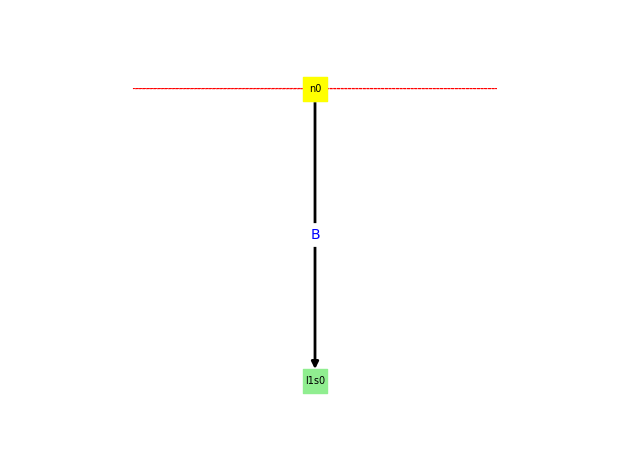

Phase # 1: inserting A
currently at:  0, None, 0


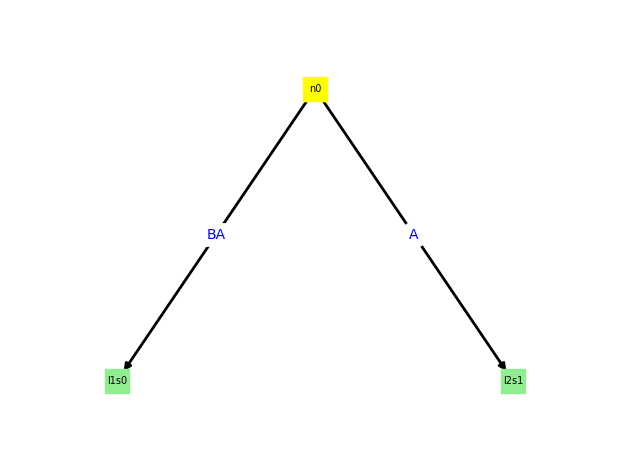

Phase # 2: inserting N
currently at:  0, None, 0


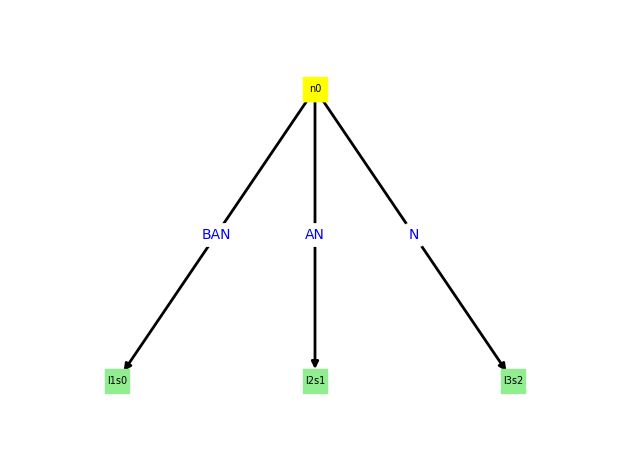

Phase # 3: inserting A
currently at:  0, (0, 2), 1


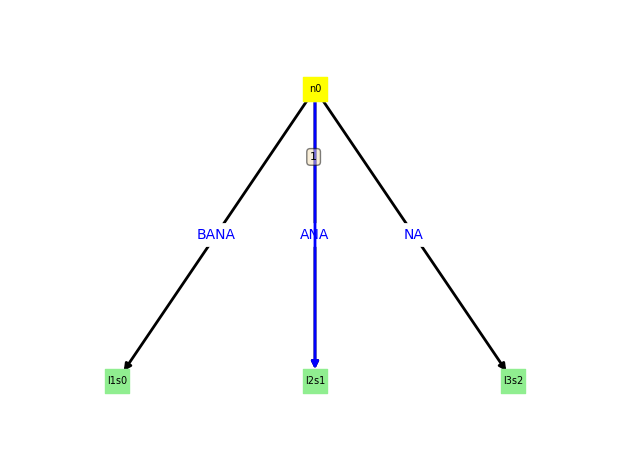

Phase # 4: inserting N
currently at:  0, (0, 2), 2


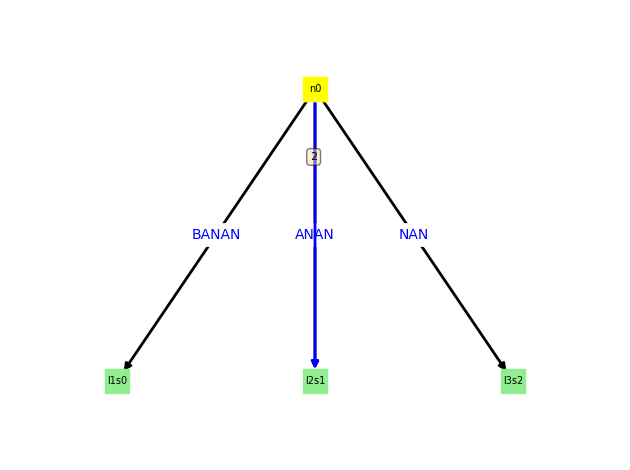

Phase # 5: inserting A
currently at:  0, (0, 2), 3


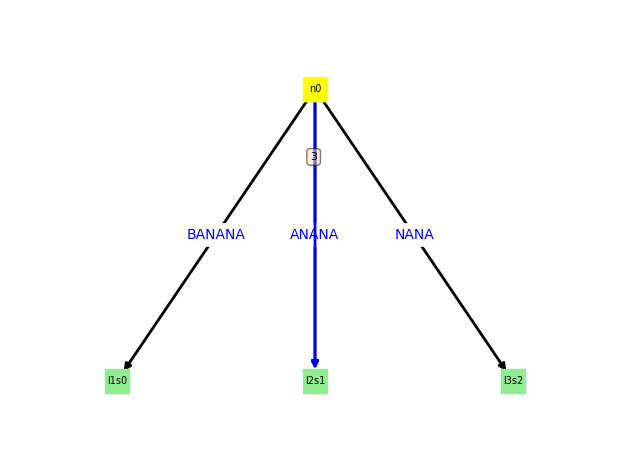

Phase # 6: inserting $
Creating new node with char $ at 0, (0, 2), 3
Created new node: 4
Creating new node with char $ at 0, (0, 3), 2
Created new node: 6
D1: Adding Suffix Link:4 ---> 6
Creating new node with char $ at 0, (0, 4), 1
Created new node: 8
D1: Adding Suffix Link:6 ---> 8
D3: Adding Suffix Link: 8 --> 0
currently at:  0, None, 0


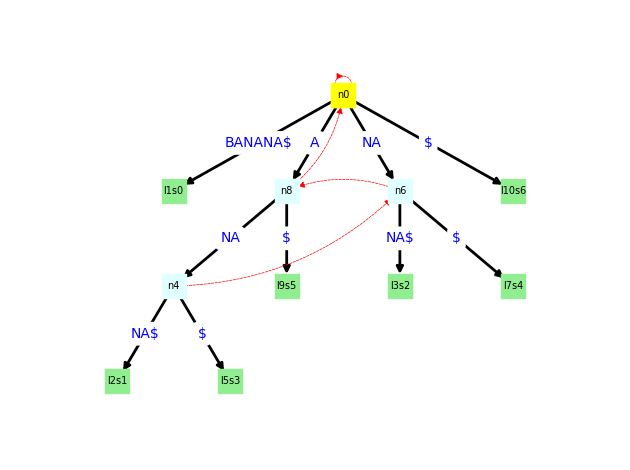

Suffix links are all valid!


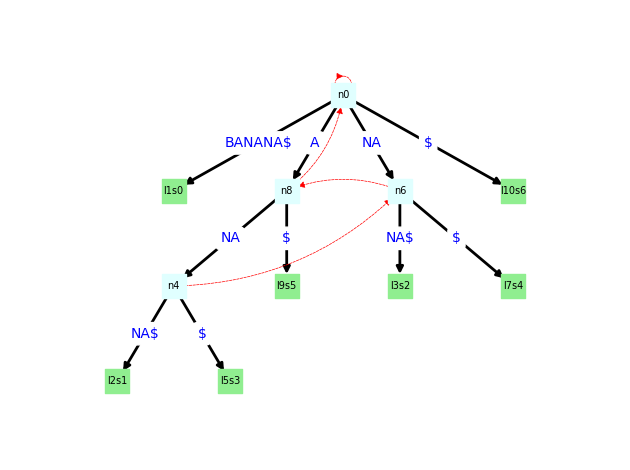

In [60]:

root = construct_suffix_trie("BANANA$", debug=True)
test_suffix_trie(root, "BANANA$")
check_suffix_links(root)
draw_networkx_graph(root)

Phase # 0: inserting A
currently at:  0, None, 0


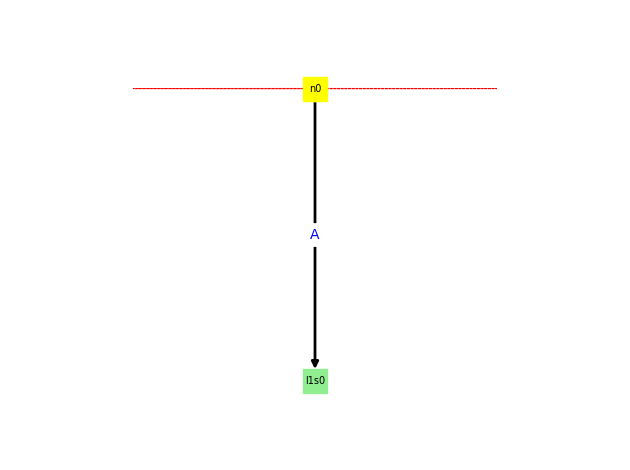

Phase # 1: inserting C
currently at:  0, None, 0


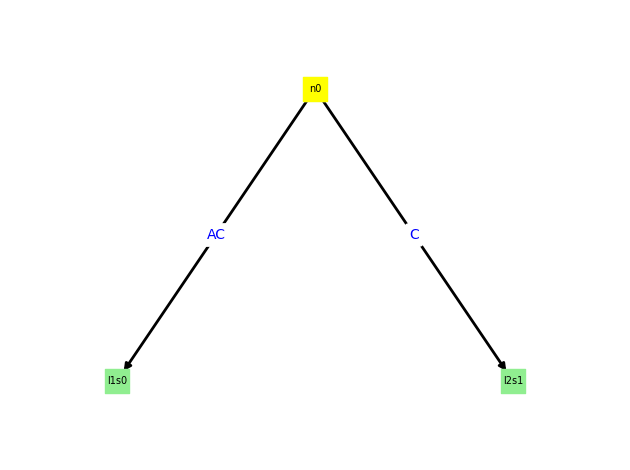

Phase # 2: inserting C
currently at:  0, (0, 2), 1


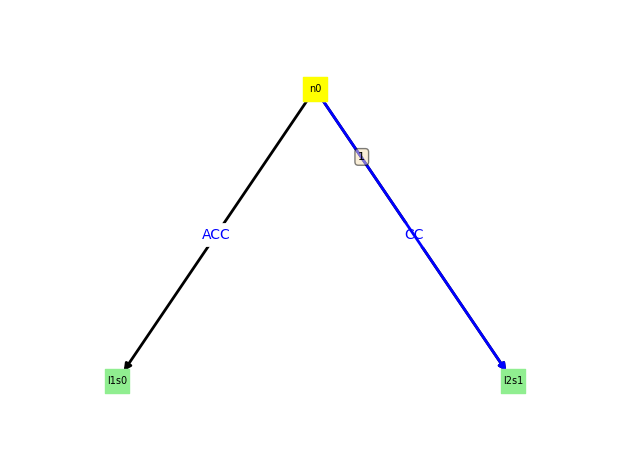

Phase # 3: inserting A
Creating new node with char A at 0, (0, 2), 1
Created new node: 3
D3: Adding Suffix Link: 3 --> 0
currently at:  0, (0, 1), 1


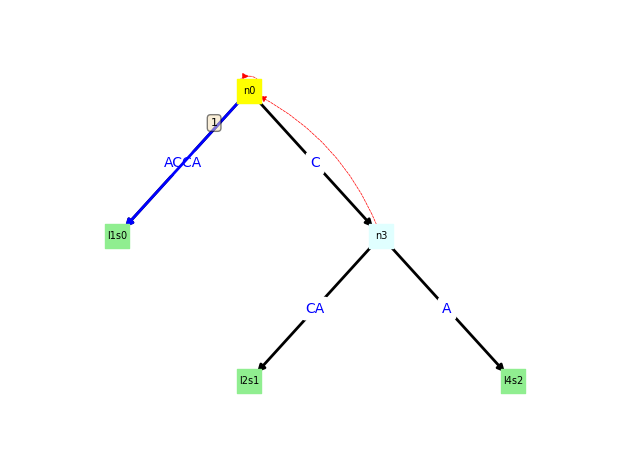

Phase # 4: inserting C
currently at:  0, (0, 1), 2


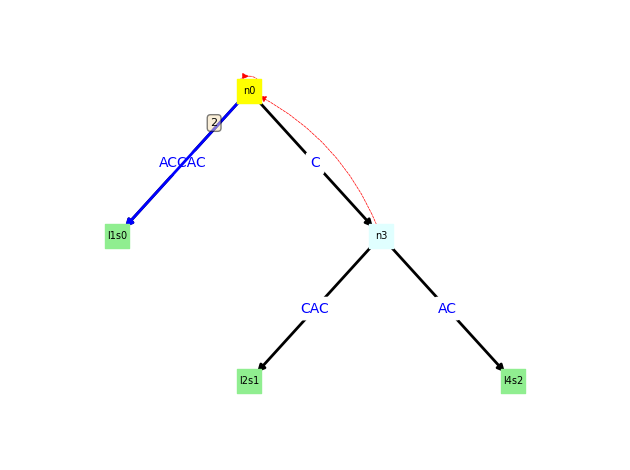

Phase # 5: inserting A
Creating new node with char A at 0, (0, 1), 2
Created new node: 5
D3: Adding Suffix Link: 5 --> 3
currently at:  3, (3, 4), 1


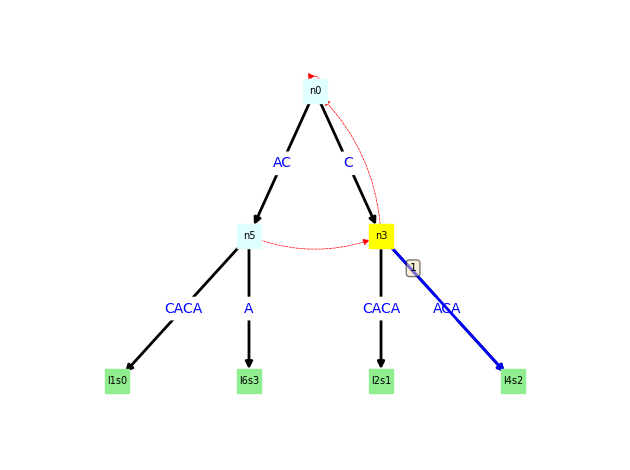

Phase # 6: inserting A
Creating new node with char A at 3, (3, 4), 1
Created new node: 7
Creating new node with char A at 0, (0, 5), 1
Created new node: 9
D1: Adding Suffix Link:7 ---> 9
D3: Adding Suffix Link: 9 --> 0
currently at:  9, None, 0


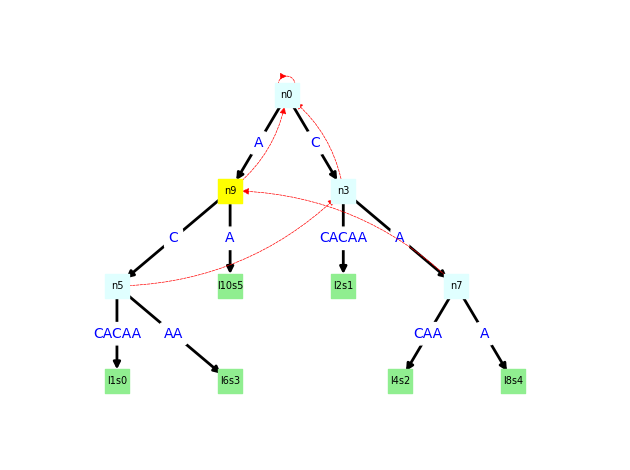

Phase # 7: inserting C
currently at:  5, None, 0


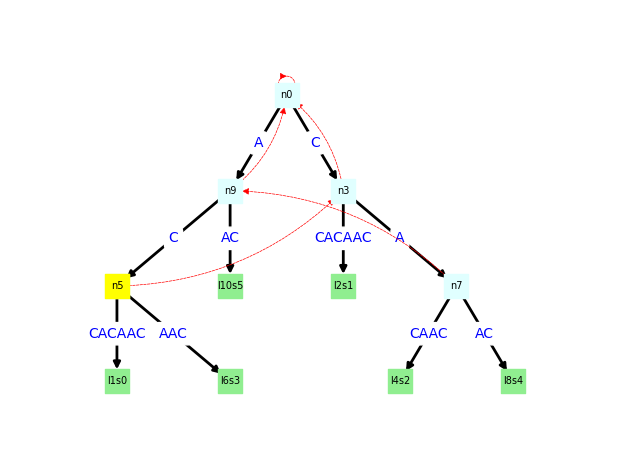

Phase # 8: inserting $
Creating new node with char $ at 5, None, 0
Created new node: 5
Creating new node with char $ at 3, None, 0
Created new node: 3
D1: Adding Suffix Link:5 ---> 3
D3: Adding Suffix Link: 3 --> 0
currently at:  0, None, 0


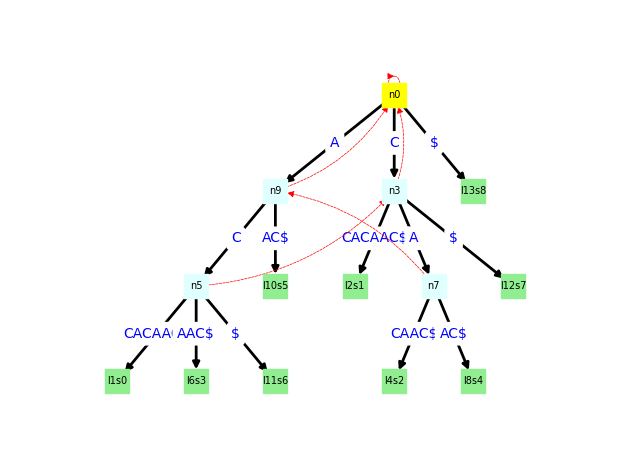

Suffix links are all valid!


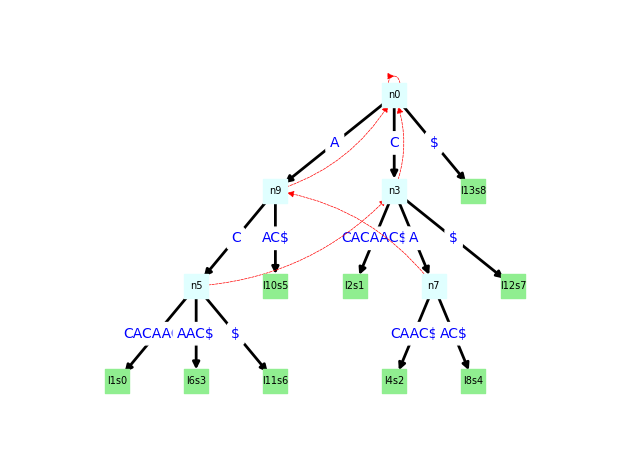

In [61]:

root = construct_suffix_trie("ACCACAAC$", debug=True)
test_suffix_trie(root, "ACCACAAC$")
check_suffix_links(root)
draw_networkx_graph(root)

Phase # 0: inserting C
currently at:  0, None, 0


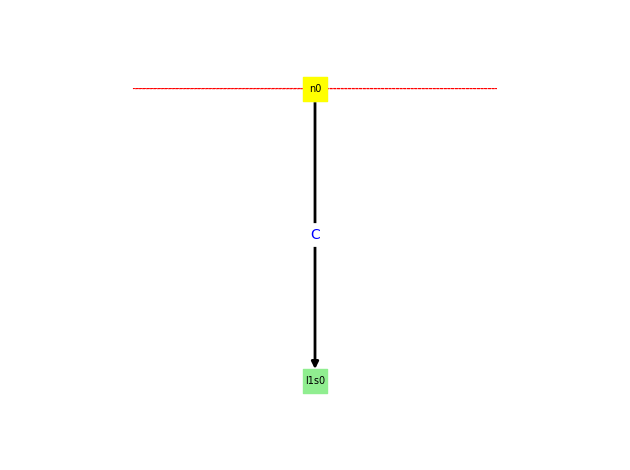

Phase # 1: inserting C
currently at:  0, (0, 1), 1


/var/folders/50/3l1vyzp13ss44tvgw3b1vw3c0000gn/T/ipykernel_26746/3166826558.py:60: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(filename, bbox_inches='tight')
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


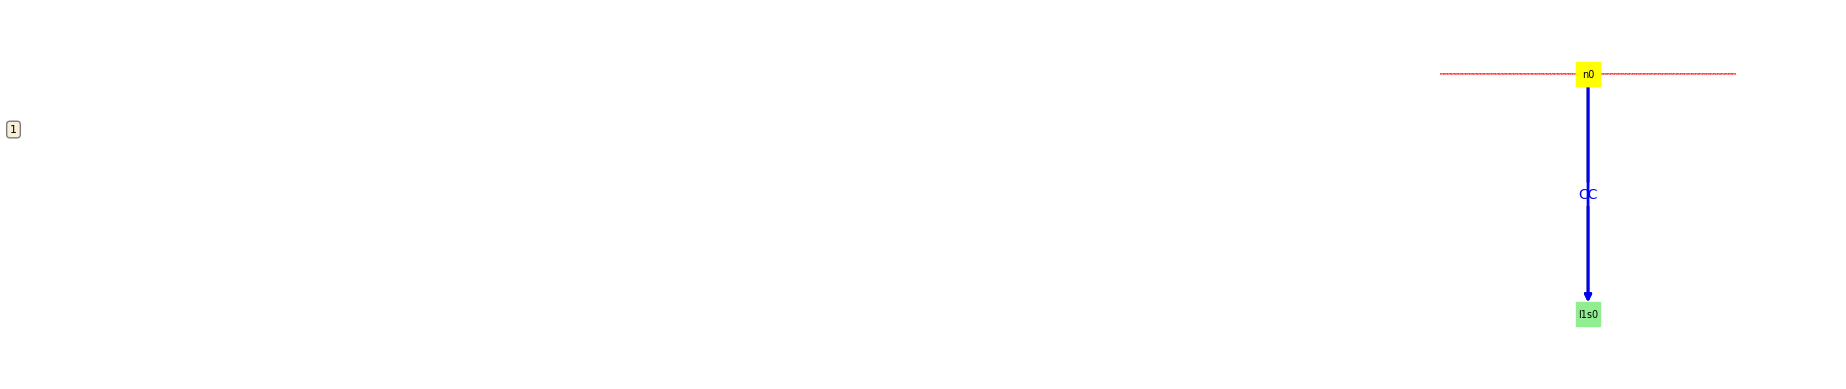

Phase # 2: inserting T
Creating new node with char T at 0, (0, 1), 1
Created new node: 2
D3: Adding Suffix Link: 2 --> 0
currently at:  0, None, 0


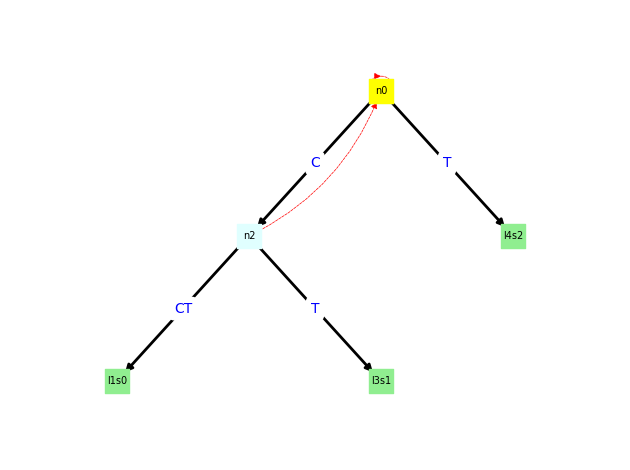

Phase # 3: inserting C
currently at:  2, None, 0


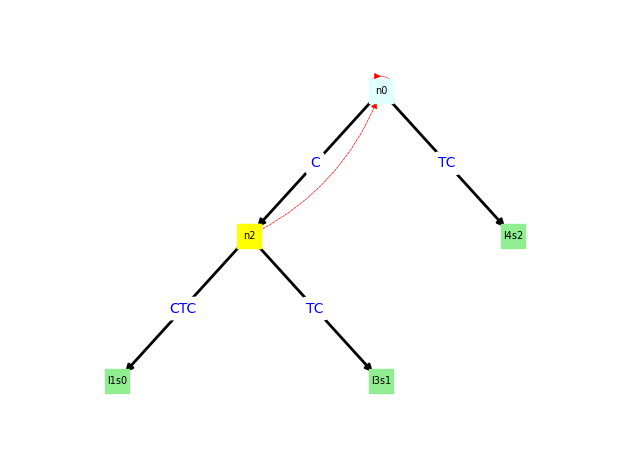

Phase # 4: inserting C
currently at:  2, (2, 1), 1


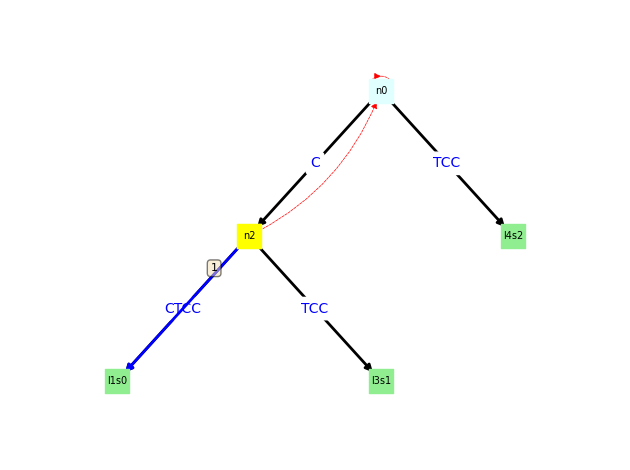

Phase # 5: inserting G
Creating new node with char G at 2, (2, 1), 1
Created new node: 5
Creating new node with char G at 2, None, 0
Created new node: 2
D1: Adding Suffix Link:5 ---> 2
D3: Adding Suffix Link: 2 --> 0
currently at:  0, None, 0


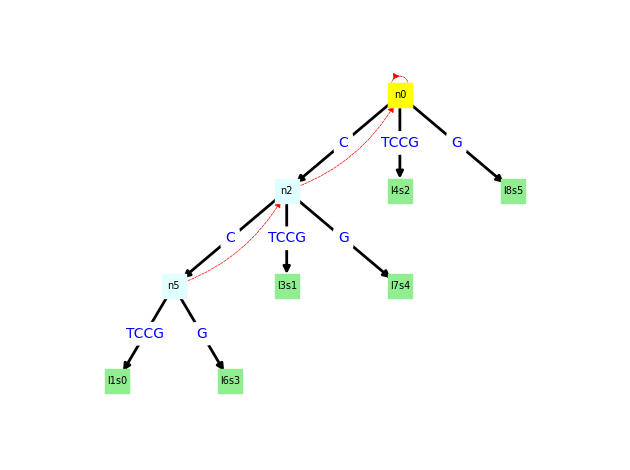

Phase # 6: inserting $
currently at:  0, None, 0


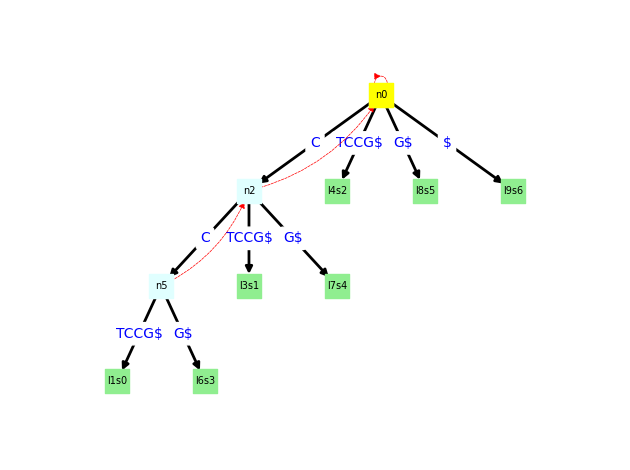

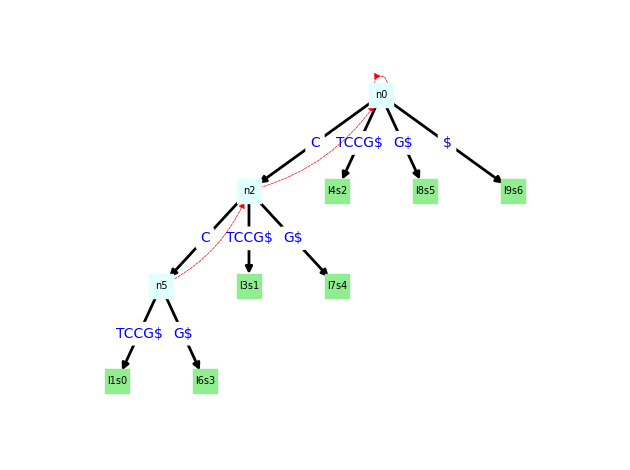

In [16]:
root = construct_suffix_trie("CCTCCG$", debug=True)
test_suffix_trie(root, "CCTCCG$")
draw_networkx_graph(root)

Phase # 0: inserting m
currently at:  0, None, 0


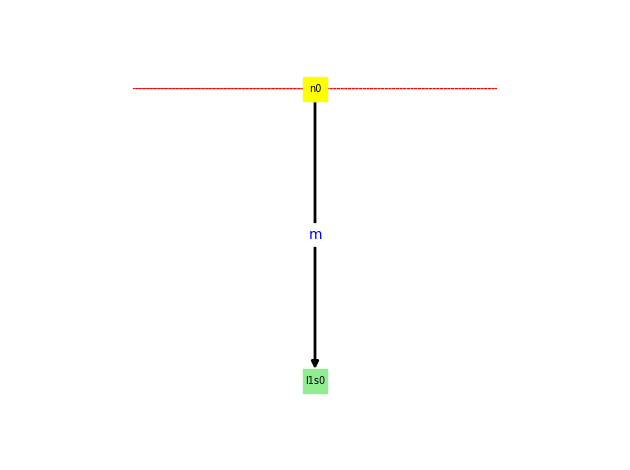

Phase # 1: inserting a
currently at:  0, None, 0


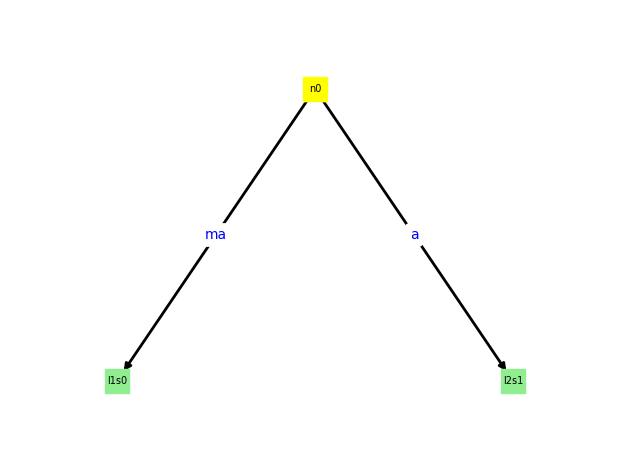

Phase # 2: inserting m
currently at:  0, (0, 1), 1


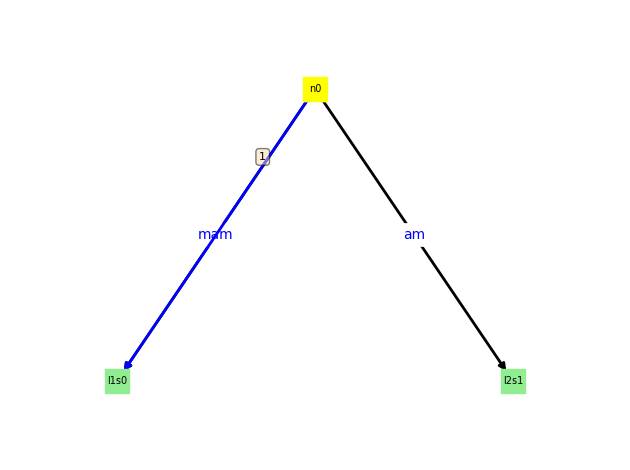

Phase # 3: inserting a
currently at:  0, (0, 1), 2


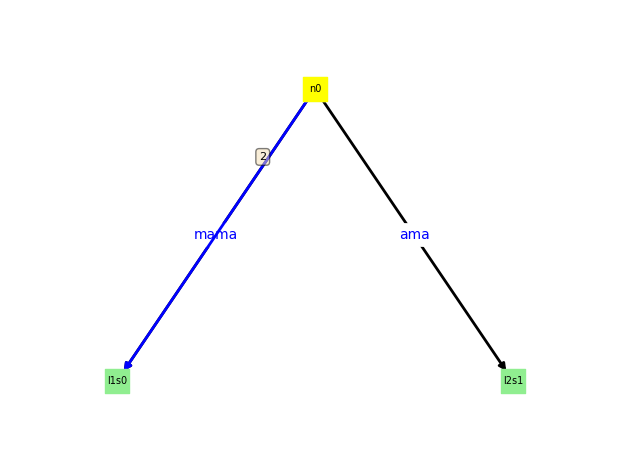

Phase # 4: inserting m
currently at:  0, (0, 1), 3


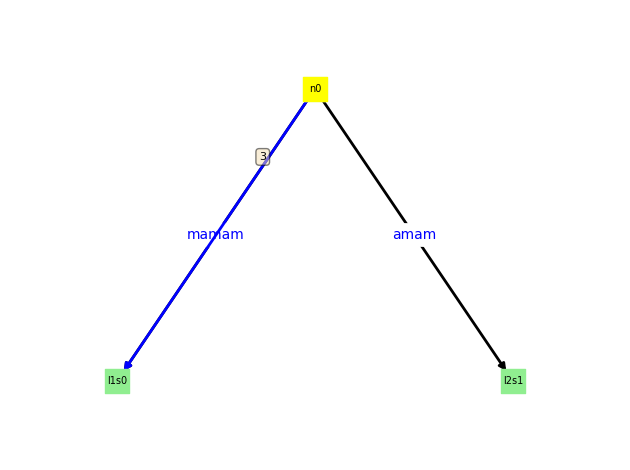

Phase # 5: inserting i
Creating new node with char i at 0, (0, 1), 3
Created new node: 3
Creating new node with char i at 0, (0, 2), 2
Created new node: 5
D1: Adding Suffix Link:3 ---> 5
Creating new node with char i at 0, (0, 3), 1
Created new node: 7
D1: Adding Suffix Link:5 ---> 7
D3: Adding Suffix Link: 7 --> 0
currently at:  0, None, 0


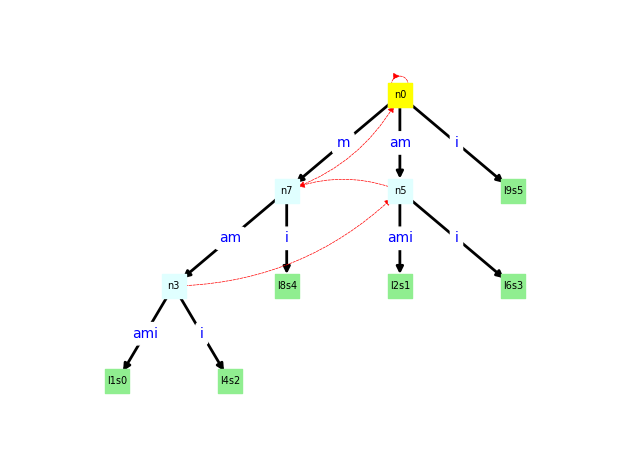

Phase # 6: inserting a
currently at:  0, (0, 5), 1


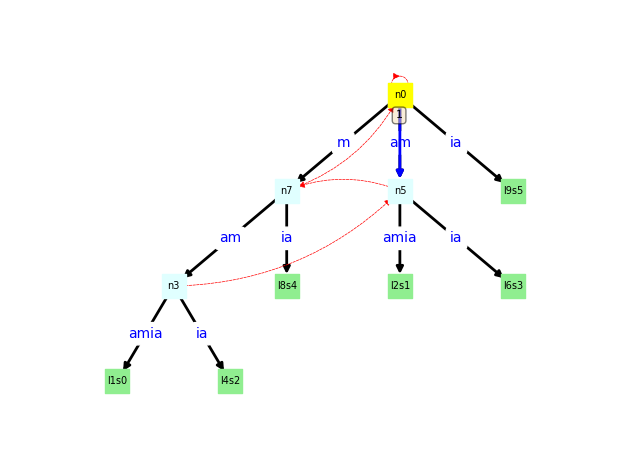

Phase # 7: inserting $
Creating new node with char $ at 0, (0, 5), 1
Created new node: 10
D3: Adding Suffix Link: 10 --> 0
currently at:  0, None, 0


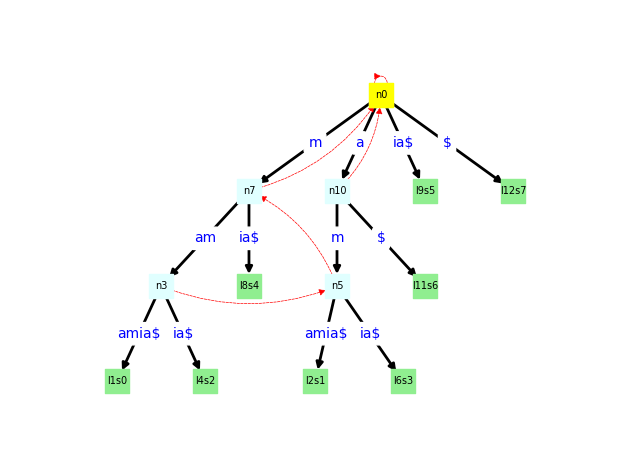

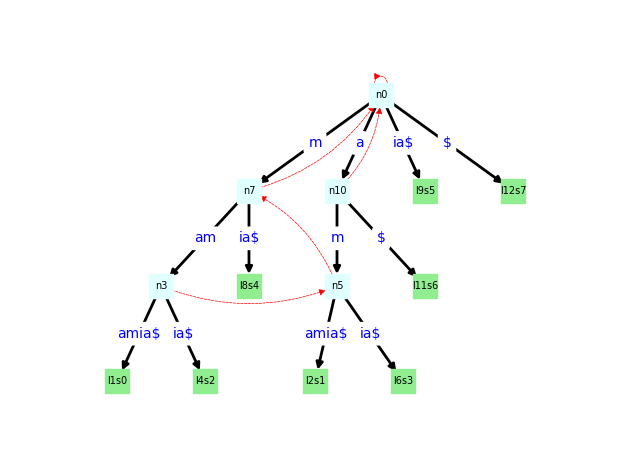

In [17]:
orig_str = "mamamia$"
root = construct_suffix_trie(orig_str, debug=True)
draw_networkx_graph(root, filename="mamamia-suffix-trie.png")
test_suffix_trie(root, orig_str)

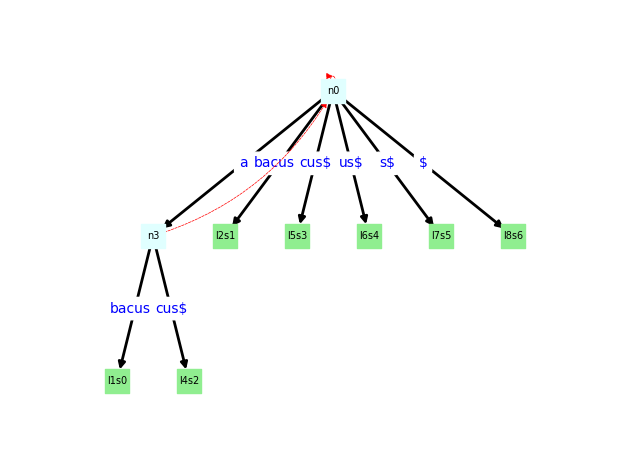

Suffix links are all valid!


In [62]:
root = construct_suffix_trie("abacus$")
draw_networkx_graph(root)
test_suffix_trie(root, "abacus$")
check_suffix_links(root)

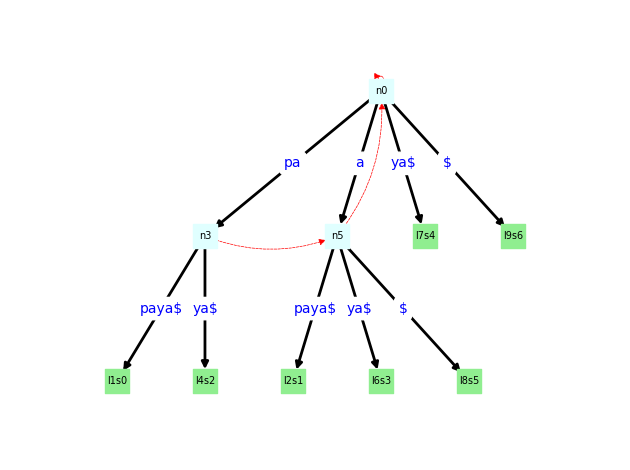

Suffix links are all valid!


In [63]:
root = construct_suffix_trie("papaya$")
draw_networkx_graph(root)
test_suffix_trie(root, "papaya$")
check_suffix_links(root)

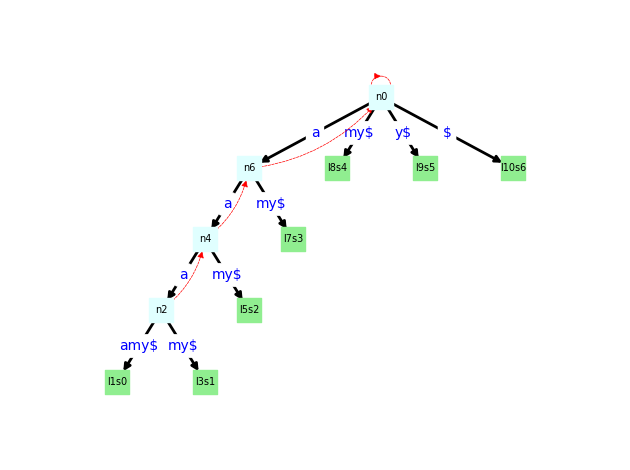

Suffix links are all valid!


In [64]:
root = construct_suffix_trie("aaaamy$")
draw_networkx_graph(root)
test_suffix_trie(root, "aaaamy$")
check_suffix_links(root)

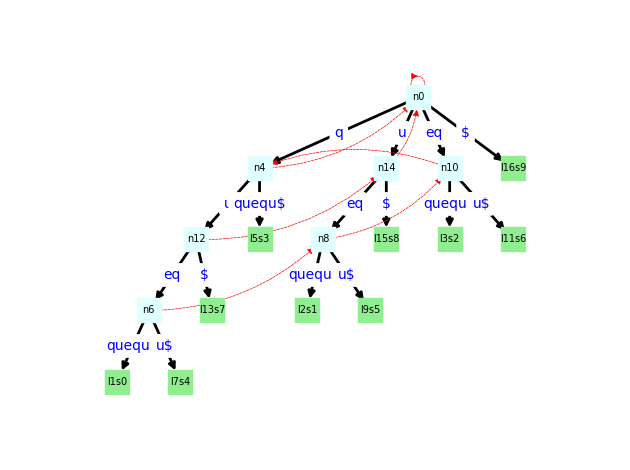

Suffix links are all valid!


In [65]:
root = construct_suffix_trie("queqquequ$", debug=False)
draw_networkx_graph(root)
test_suffix_trie(root, "queqquequ$")
check_suffix_links(root)

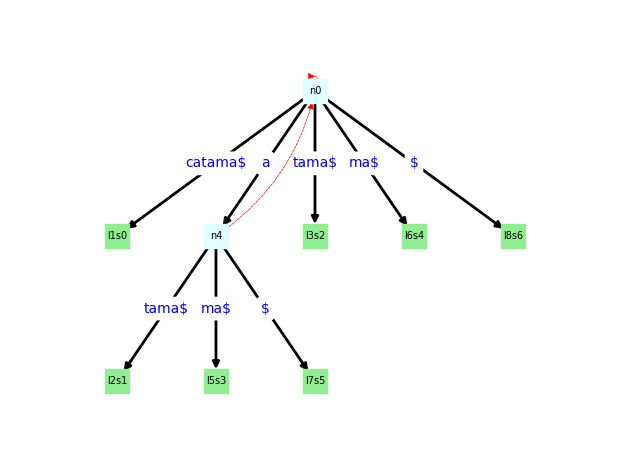

Suffix links are all valid!


In [66]:
root = construct_suffix_trie("catama$", debug=False)
draw_networkx_graph(root)
test_suffix_trie(root, "catama$")
check_suffix_links(root)

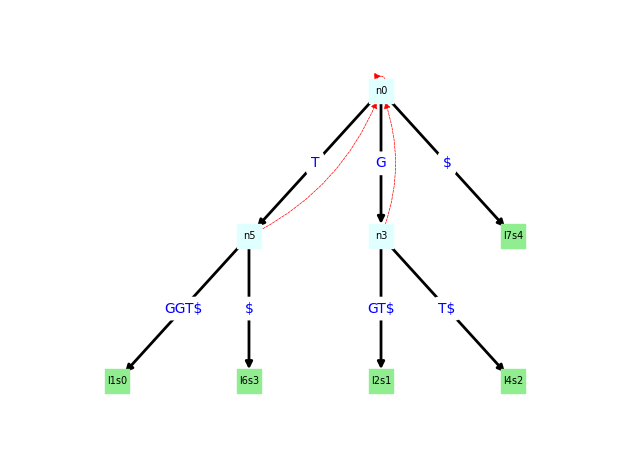

Suffix links are all valid!


In [67]:
root = construct_suffix_trie("TGGT$", debug=False)
draw_networkx_graph(root)
test_suffix_trie(root, "TGGT$")
check_suffix_links(root)

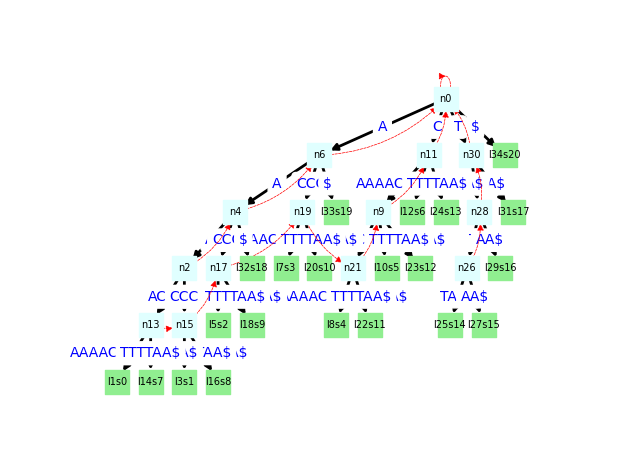

Suffix links are all valid!


In [68]:
root = construct_suffix_trie("AAAACCCAAAACCCTTTTAA$", debug=False)
draw_networkx_graph(root)
test_suffix_trie(root, "AAAACCCAAAACCCTTTTAA$")
check_suffix_links(root)

In [69]:
from random import choice

def generate_random_str_and_test(l, debug=True):
    chars = ['A', 'C', 'T', 'G']
    s = []
    for i in range(l):
        s.append(choice(chars))
    s.append('$')
    orig_str = "".join(s)
    print(f"generating suffix trie for {orig_str}")
    root = construct_suffix_trie(orig_str, debug)
    #draw_networkx_graph(root)
    test_suffix_trie(root, orig_str)
    check_suffix_links(root)
    print('\t Test Passed')
    

In [70]:
for i in range(10000):
    generate_random_str_and_test(50, debug=False)

generating suffix trie for CCGCTGGGTGAGGAGGACCTGCCGGATGGGAGAGACCAGTGAAGTGCTCG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GTTATGGATGATGCAAAGGGAGGTCATCAGAATGCGCCAAACTCGATGCC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AAACTGTGCTCCCTCTGCCGTAATTGCAAGGGAACCCCTTGCGCGAGAAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CAAATTGCTACGCATTTGATAACCTTGAGAAATAAAACCCGCAAATACCG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AGGTATTGTACTTGGGGGGGCACCAAAGTTGAATAACCAGGATATAATTC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CCCCAATCTTAAGGAAGGCCCGTGACATAATAGCCTATTGAGAACTACCG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ATAGCACACGGCGCCCGACCACTCCCGGGAGCTATCTATACCACTTTCGA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CAACCGGCACGGCTGCACGGTGGAGCTCCGGTAATTGTGGGCCTCTAAAA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCCCT

Suffix links are all valid!
	 Test Passed
generating suffix trie for CTTTCCCGCTCAACGGCAGGCTATTTCGTTACAGCTGAGAATAGTTTGTT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GAATGGAGAGGTGCGATCCTCAGTGCCAACAAATTATGAGGGCGGGACAA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ATTATTGTAATCAAGCTGGCCCATGCGAAAATCTAGTCTGGATAGTGGAA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ACGAACAAGAGCAGCTCTTAAGTCTATCTTATTGCCGGATTCGCATTTGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TGGATAATCCTGGCAAAGGGGGGGCTGTAAATGTATTTGAATTCATTATC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CACACATCAAGTATCCGGTATCTGCTATACGGGGTTCAAGCTTCCATCCA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GATAAATAACGCTGGTTGTACATCGACTATGATCCACTCAGCTACGGTTA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AATGCCTACACAGGTGGCACCTCAGCAAAACCAATTAGCTGGACGATATG$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for TAGAAAAATGACCATATGGTCGTAAATGCCCCTGCGTCATCCTGGGCTCC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TTTTTTCTATGAAGTCAGGACGCTTGATAAAGTCGCGAGGACCGAGTTAC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GTAAGCGGGAACAGTTATGAGGCGGATCAATTCCGGAGAGGAAACGGGTG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ACACTTTCCCCAGGGGTACGGATACGAAGGCGTAGCAAGTGTATATATAC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TTCGCACTCAACCGGAATACGACTCTGGACTTTGGCGAAAATGGCCAGCT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ACGAGCCATGATATTCTCTTGGAAATTGATACTCCTTTACCCTTTACGCG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CGTGCTATGTTGTTCCTAAGTGTTGGATACTGCCTCTGAATCGTTGATAC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AGGAGCTGACCAGGTACTGATATTCCTCCTTATTTGATCCGTGTGGACTC$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for CAAGCTAACTAGGCTTTATTAGACATACCTACCTGGCGGGGATCGCCCTA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCACTCAGTCTGCGTCGGGCTCCGGTGCTGGCTCGAGCTGGGCAATCCTT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CCTGCGTAAAAACTTTGAGGAGGCAAGTGGCGTCGGCGATATTGACTGTA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GCTCACCTAGAACTTTCTAGAGCTAGTGGCGTGGTCCCCGCCTTGATTCA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AAGACGCACTCTAAATCGCGGAAACGTCGGCTGGTCTGGAATCCATATCT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TGCAATAAACATAGTGAACAAGTACTGAACAGAATCGGACGTACGCCGAC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GCTGGGAAAACCAAGCACTACTACAATATGCGTGTAAGCATCTAGGATCC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AGCACCCATTTCAAATAAATACCTTATATGAAGCTCCACCCCTCGAGTAA$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for CACCGCACAAATCCTGGTACTCGGGACCGTTTCGAACAACTTTCTAAACT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTTCAAGAATCATTCGCAGGGCCTAGCGACCAGAGCTCACAGAACAACAT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TAATCGGAAAAAGAATGTGAATTGCGCAATCCGCGTATGCGTTAGGTTGA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AGCCAGATCTGACTTATGTCATGGGCTCCTCCGGATCCGAAGTGCCAGGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTCGTTTCTACCTGGAGCCGTGTGACCGGCAGCCCCCGGTAGTCGACCAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GAGGGGCATAAACTACATAGTCAACACTTGTGTCATCAGTGTTGTGTCCT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AGGGGAAGCCACCGAAAAGCACGCTCACGTCGAACCCGTGCCATTTCCAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CGCAATAACGCCACTCTTTCTTTTACCCACTACGCAGGCAGATCCGGAGG$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for CTTGAAGTCCTCCAAGGGGAGGTGGTCTGGAAGCCCTTTTGACGACGTCA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTGGCTTTCTGGGTGGGCTCCCTTTTAGGAGGGTGCGGTCATTTGCGTGC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AGCCCCATTACGAGCTACACTTCCTTGAATAATGTTGCATCCCGGCCAAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTCACTTTTAATCGCTTTCACAATCAAAATATCTCAATACGGAATTCGTA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ATTCTGACAGATGTTGTGTCCCAAACGAGTACTTATGGAGTTACACAGCG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TGTGTGTAGCCGCACTGGACTTATCAGGGGTAGTGACATCGCTTCGAGTT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CGAGTTTAGTCGCTAGATTTTAGTAGATCAACGCAGCTAGGTATAACTCT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CAGCGTATGAAATCCGCATCTTCAAGACCTATCTGCGAGTTACGCGTTTG$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for GTCAGAAATTGATATATCTAGCTGTACGTCAGCAAGGAACGAAACGGCTA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TAACGTGCGAGTGGCTCTCCAAATCCATCTCTGGCGGTACAACACGAAGG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TTAACGGACATCAAACACGGTCCGGGCTTTGTGTGCCCCGAATCGCTGTG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TATTTTTTGGACTCTGTTTCCTCAGGAGAGCACGAAGGCATCAAGGCAGG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TTGGTTCCCTAGGTATCCGGAATTTGCAATCTGGTTCCTTCGGCACCACG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTATTAGCAGTCTCTCACTCTGTTTTCGTTCGCGAGGGTCCACCGGACGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TAGCTGCCGCTAATACCCCAAGAGTGCGACCACGGGCTACGGTTAAGATC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GTAGAGCACGACTTATATTGACATGGATGGGTGTAGTGCCAAAAGGACGC$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for CAGCGGGTACCTTTCCAACGGGACATTCCCTACAAATATTGAATGCGAGC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CCACGACTCTAGCACAGGGGATACTCAGTTTCCTTCTGGACTCTCTCGGC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AGACACACATTATAACGGCGAGTGATAATGCTCGCCATGCCGGTCCGTGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AGAGTTTCTGATCACCGTAACAAAATCTGCCGAATAGGATAAGTCCACGA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTGCTTGTCAAACACGGTGCTCCCATATGCCCAGTCTTGTACATCTTCCG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ACCACCTCCCTCGCACCGGACGCGATAGATAGAGAAGTATGACATTCCCT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ACGTCGTACGCAATGACCTAATTTCGCCTACCAATAGTGTTACTATACTA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GCAGAGGCGGGATTTGAGGACAACCGAGTATGGTCACTTATGTGTTTGTT$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for TGCTTAATCACCATGATACGACCACGTTGCCCAGAGGATAGCCTTAGTCC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AACACAGGGTCTAGAGGGTACAGCATCAGAACGAGGTGAGTTGACAGGCA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CCATTGGGTCCCTTTATTGCTACCCTCGCAGTCGGTGGGGGATTAACCAC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CAAACAAGGACAACACTATCTCCGTGTCATTATAACAGAAGCTTAGATGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTAGCATCTACATGTGCTGTAAGGTACAGTGGTTTCATTTTGAGAAGCTT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ATATATACAATTCTGCTCAACGGACAGTGGTCCCAACTAAGACGAGTGCT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCTTGACCACCCTAACAACTCCAAACTACCAATACGAGCTTCGAATATCC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCGGCACCCCTCGACTTATACAACCCATATCACAATATTAGTGTCGTGTC$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for GTACTACCACTCCCGCAAGTTACGCCCCTGCCTAGCAATAACAAACGTAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CCAGACACCGACTATAGGCGCGGATCGTCTTTTTATATAATGGTACTTGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GACCTCACGGTACTCGTGTCGGCTCGCGTTTCGATTAATGTACGTAGATC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCATCTTGCATTATAAACGCCACCCGTGACTATCTCTTATCAGAAATTAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GCAAAATGTTCAACTGGATGGTCCGTACCAGTCCATCCCGTGCCCGTGTC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CGACTAACAAATCCAGCACAAAACGCTGTGATATTGTTATAAGCATTCCA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCGCACCGGTCGCTGGAGTCCGATGGTCGGAGCATGGGGAGCTCTGAGCT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TTGCATCCGCTAGGTTGGCTAATAGCATACTTGACTTGATGTACGGAACA$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for TGCCCCCAGAACAGATTGATCATGGTCTCACAATGGACTACAAACATCAT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ATCGAAGCCGTGCGGAAGATTCGCTAACGAACCGGGCGTGCTGCAGACCT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AATTCCAATATGAGTTTTGAACAGTCTGTAGCTTCTCTAATTAGTTGTGC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCGTAGCTTATCGTCTATTGGAGTTACAGCTCCGCGCACGCGATGCAGTG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GACAGACTTCCTTCGATGGATTTCTTAAGATTCGCCCTATCCTGTGCTGC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GAGCATCACAGACTCCAGTGCGGCCGACCCGCCGGCACGGAGAAGCACCT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TGTTGTAATTACTGCCTGCTGAGCCGGAATCAGCAAAGAGATGCGGCGCC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TTATCCATAGATCAGGGGGAACGACCAACGGTGTTGGAGCTGTTGCACGG$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for GTGGCGACCCCCAAGTTTCGCGCGTGGTTAGCCAGTGACGGTGTATCACT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GTTAGAAATTTGGTAAAGGTTAGAGTCGTGACTCGAGTGACTGTAGGAAC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AGGGCATCTGCCTAGCGGATATCGATAAAATAAAGAAGCTTTATCACAAT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CGCTATAGCCTTTCCGGACGGGCCATTCGACTTGTCTGTCTGCTTTGCTG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ATCAGCTACGAATTACCACTGTCCTTTTACATACCCTAAACCACGATTAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TGAGAGTATGTGGTTTGAGTTCTAACACCTACTTGAAAACATACCTTACC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GAATAGAGACTATGTCGCTATGTCTAGAAGCCTCCGCCTCGCGCACTTGC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GAGCCCTTGGAGTCTAGAAAAACTCCGAGACTGCAACCTTTTCGGTCGGG$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for CACTACCTCCGCGAATAAATGTGTTCGGGAGGAAAGGAGCATGCAAGCGA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ATCCCTAGTGTCGTCGACAGGAGTCGCCGCATTATGGCTGCTGAAGTTTC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CATATCGTAGTGCCTAGATAAGGTCTCTGTCGACCACATCCTCCCCGTGC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CCCCTGTGCATGTTGGAAAGAAGCCCTCGGTTGCAATATCGGTAGCTTGG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GGTCCATTTTTGGTACTATGATTTAACTTTGATGCAAGAGTAACTCCCTA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GCTTCATTGTACTCCACAATCATTCCACATCCAGGCAACGTAAGTGTGAC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GTCACGTTTACGCAATAGGGCATACGCATACCTACCGAATCGTACCCGGG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TTTCCTTGGCAAATTGCTGTGTCGTATCGGTTCTTCTGCAGAGCCGGGAC$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for GTTGCATGTTAAAGGGAAATAATCAATTTGTCCCATTCCTCGGTGCTAGC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ATCTTGGGGAGCTTGATTTTAGCACGGGTGTTGGGGCCAGCACGCTGGTG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GTAACGGTGGACATAGGCGCACCAACTTCACTGCGGCAGGGATCCTGACC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTTGGGTTGTATTCGACGTGCGCGAACTAACGTTCGCTAGGCTAACTAAT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCGCGTTCAGCCTTGACTGTGTCGGCGAAACGGCGGGATCAGTGCAGATA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ACTGGAACTGTATCACCGAGTGGGCTGCGGTGGCCGTAAAGACATCAAAT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ACTCCCGGTATGCTCAATTTCTATCATCCCTAGGCGAAGACTTACACTTC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GGCGTATGGAGTTGATGGATGTATTTAAAAACCTCGCAACGGCATAAGCT$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for AGCATCAGATTTCAATTCCGAGGATTTAAACCCGCCGACTATAATGTTTT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GATCAGGCAAACTTCGATTTTTAGAGGGGACCGGCTCCACGTAGATCATA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ACAGGAGAAGCTGCGTACGGCCTACCCTACGATTAGGATGCCACTAGAGG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CAACACGCACTATGTCTGAGTGATCACGAATAGGTTTGCGGTTGGTCGTA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TTTTGTGTGAATGTAAAGGAAACAGTCGGTAATCGCGTTTTCGCCTTCGA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GCTTGGCCTTATTAAAAATGGTGGCCCATTGACTTGGGTATTTGCTGAAA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ATACTGACTTGTTGGATTCTAAACACATCTCAGAGTGCAGGCTTTAAAGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GGTCATTCTCCATAGCTCCTGTCGGCGGTCAAAGAGACTAAAGGGAAGGC$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for GGAAGGCCTCTAGGTCGGGCAGTGACGCATGCGCCCCGTCACTAGTAGCT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ATGACACCACCTCCACACCCCTCTGGGTGCCCCGGACTTGGTCAGGCGGG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GGGCAATTGGCGGTTAGATAGCATGAGACACCGCAAAGACCACCACCGTG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GCAATGTAATTTCTGACAACTGTACCCTAACATTAGTTGGACATTCCTAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTGTCGCCCGATAGTCTCCTACGAGTTTAACCACGGCGTTGCGGCCGTCC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GGTACCTCCGGTGACTTGAGTCATTCTTTCATCGGGCTTGGGCTCTCTCT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AGATTTAAGGATGGGAAGATCTGAGCCACCCTGAGCCGAAAGTTAGCACT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CATAGACTGGGGATGTGACACATCTACGAGTGCATCCGGATAATTCTGTC$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for TCGTCCGAGTCCGGCTCCTTCCAGCGTAGCTGACGTCAAATGTGATCAAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TTAGAACCGCGTTTTGAGGTCAAATTCATTCCACGGCTGGACCCCTAATC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCCGAAGGTTGTCGTGTATTCGGACGAGCACAGTAATTACCACAGCGGCG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TAGCGCCGTCATTTGTCTCTAGGGCACGAGTTGCCTATTTCGAGAGAAGA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GTACACAACGGAAGTGCACGCGGTTACCTTATCGACAGGGTAAGCGCATA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GCTTAGTACAAACAATCAACAATCTGGAGATCATCATATCTGTCATAAAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTATACTATATAGCAATGAAGGCATATCACGAGAGTACTTGCCAGTACCC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TGGGCATATGAGGTCATGGGGTCACGCTCCGATGTACGCTGAGGTTTACC$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for TATATTCGAGACAATCCGCCAGCGTCTAAACACGTTCTCTGAAAACACTT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CAGACGCTCATCATCACAGAAGTGTCTAGTCGAAAGTAACAATTCCACAC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTAGCCGGCTAGGGTGATTGAAGTTCGCGTAGGACATTACGTTAGTCGTG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GACTCGCTGGCATATACAGCATTGGCAGTTATCTGAATGATCCTCTCCGA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GCTCGACGACTCCGCCGTCCGGTGAACATTTAAGGCGTTAAGAAGTAACT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCGTATTGGGGCGCGCTGTCTCGCTGTTAACTGGTATTTGAGTTGTGTCA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCTATTCGCAGTGGTCCTGCCTCACATATAGGGTCGTGTGTAGTCTTCTT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TGCACAGGATGGCAACAATAACGCTAAAGCCACCTGTGGACTTGTCGTCT$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for ATGACGTCGAAGCCAATAACCCGAGAGTGGAAGAAATTCGCCCCCGGTGC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CCTAGCGGGTGCGACACCTCTCACTCGTTATGCCCCCTTCAGGTTACAGG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GCAAAAGCCAGCTCGACTGTCAGGTCCATTTTCGAATTTTATGGAGGTGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTTTTGCAAATGCATTGTCTTTGGATCAGACCGGCTTAAACCTACGCTAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ACCTTCTAACGTCATATATGACCTTACACTCGCCCAATACTCTCTTGTGA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TAGCGCCTCATTAACTGCAATACTAAACGCCTGCTAGATCGGCAGGCATA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CCCACGTGGGTACAATTAAACTCTCTAACTTCCTCGGGCTGGCAGGCTAA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ATCAGTATTCGCGCATCATATAAAGATTGCCAGAAGAAAATCGTCTTTGT$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for TGGCTTCAGAGCGCACCACATGTCTTCTCTCTAGCCGTGGCTCACAACCG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ATTCCGTGGAAGTGTTTGTATTGGGCTCCAGTTACCGCTGCGTCTCTGCA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GGCACGTCGAGGGCAAGCGTTCTTATAGCCACTGCAATCGCGTACTAAAC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GGAATCTAATGCCTGTATTATATTTGCTCGTTGGCTACTAGATAGGCATA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCAACTCTAACGACCAGCGATGCAAGAGTCAAACGGCGAGTCTATAGCAA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTCCATTATGGAAAATGGAGATGAAAGGCTCTAATTGTCTCGAACGACTC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCGCCGTAATGCGTCTCCCGCTCCGCAGTACTAGTCGTATGTAGACTACC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ACTCGTACTGTGAGCATGATTATTAGAAGATACTGGTTCAAGAGCGAGTG$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for GGATAGGTCCCAGGGCAAGCATTACACTATCGATACGCGTTATTCTTACA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ACTCACTAACAGCTATCATCCTGGGTCCTCGACGAGGACTGTTTGCTCAA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TACGACATTGGCCGTCACTTCGTCTACCTCCGGGAAGTAGTGTGGAGGCC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GCTGTTTTGTGCAAGACTATATGCGTCCATCCCAGGAATTCTTTTATAAA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CGAGTTTCCACGTTTGGAAGGTATTCAACAACCTCTAACCTCAGGCGATA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GAATAGGCAACGTCCTAAAATTCCTTTGGGTCCAGGTGACGATAGTCTGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TGGGATACGCTCGGGCGTAGAGTTCCTCGGACGCTTATGGAATGGTTACG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TATAACCCTTGTTCTTACGCTGCGCAGTTAACGATCAATGTAGGTCTGGG$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for ATTTGGCGCGCAAGTGAAGAGCCCATGCATTCTTCCTGCCCTCATCAAGC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TTGCCGCTCCGATCGGAAGATTACTGAATAGTCTTGCCTACGAACATGAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CGCGGGCCGGTAGCTCGGACGTATGACATCGCACGGTCCAGTACCCCCGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ACGTCAAAAACTTTATGCAGTTCGTATATCCATCTTCATTGAAGAAACGA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CGATGAATGTACGTGGATAGGGTTGCGCTTTGGCTCGAGGTATTTTCTCT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CGCTGGATCGGGTGTCACCTCGCACACTTGTAGTAGAGTAGATTGCTCGG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AATCTACGGCGTCCGAACCAGTTGGGACAGAGTCATCACCCCTACAATCC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CGTCTTCTGCCTAATGCGACCAAAAGCGTCACGCACTGCTTAGAGCGCTC$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for TATGTACGCACGTGGGAACGTGTGGAACCCGGAGAGGACTGATTGTGCCT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GGCGCCTTTAGCTGGATGTGCAAGTAATCTTCACGCGCGCGGAAGTGCAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GGCGGTTGTTGCATAGCTCGTGTAGAGCTTGCATGTGGCTCACCTACCGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTTAGTATCGATTACTCAGGGCACACAGCTCCGTAGATCCCAGGCCTCCC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CCTATCAGCGTGCGCCGAGGTTAATGTAGATCAGCACCGTGTAAGTCAAC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AGGATGAGGCGCTAGGGTGCTTCTGACTAATACCGCGGCGCGGGCGCCCG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CATCCGGAATTCATTATACGTCAGTCGCCTACCTATTAGGCTACGGTCTC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AGACATACTCCCTGCTACCTAGAGGTCCGAAACTTCCATCACAATAATCA$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for CCTTAGCGTATGTCGAGGTCGTTCAGCCATCTTAAGAGTAGACACCCTTA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TGCCATTGTGAGTGCTGGGTTGTACTGTGAGATGGGAATTTTCGGTAACA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GCAGGTCAAACATTAAGCACTTTGCCGAGACGTATAAAAGTCCTTGTCGA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ACGAACCCCCGCTATGTGTACGGAAATGAACTGAAGGAGATGCTTCTATA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTTGGGGGGTGATAATCTGAAATAGGGGTTCGCCAGGAGAAGTCAGAAGG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GACGAATGGGACACTCCAGCTGGTTCCTCTGTGCCAGGAGATTCAATAAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CGGAGTGAAGTACTTTAGTGCATAAGCAGTGGGATCAGACAAGGCCTGAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CGTAGGAACGCTTTTGAACTAAATAAACCCATAGACTAGGCATATATCCC$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for TAGGGAGGCTTGTTTCTGCGTCGTACATTCGCGAAAGACATTCCATGGCG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TTGTTGCCACACGCACCCTTCTTGCCTCTCATCTTGTATATAATAGCAGC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ATATTCGCCGATTATAGGCCCTGCCTTGCCCTCCAGCGTCAGAAACATCG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AAGTTTGACGCAGTCATTACACATGTAATTAGTGCTACCGAGTCGTCTTG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TAGACGGTCGCCCCCCGCAGGGCACCGAGAGCTCACCTATGCTAGTCAGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TGCAAACACACCAACTCATGCATGACCTAAGATTGCGATTCTCTTGACTT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCTTATACCGCCAATCAATGGGGACAGACCACGGCTGAAGTCCCCATAGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GCCACAGCACGGAACAAATTATCTGAGCCGCCCACGGGGCGCCAGAGCCA$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for GGTTAGTTATGTTGTAGTTTTAAGGTAAATCGATTGGTCGGCCAGATATG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CACTACAATCAACCAGCCAATCCATTCATACCTATGAGGTAGTACGTCGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GGAACACGAACGTTGGCATCCCTATAATAATTTGCCGAATCGCAATAGGC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AAAAGAGTTTGTTTACGACAAACCGGCTGTCACTCCCTGACAGGTCCGTT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CCCTTACAGTCGACTACCGAGGATCAGGTGACGCAGAGCTCCGCTTCTAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCAACTTACCCTAAGGTTACGAGAATCATCACTTTACAGGCGTGTCCGGC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ACCAACATCTTAGAATAATGGGAAGGTTCCGTTATGCAAGATCGGAAGCC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AGATGGAGCAGCTTATCTGCCTACCATTTGGCCCATACGTCCCAGTTATC$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for AATTGTCAGGAACGGGAGTTTGCTGTAACGGTCGTGACGATGCTGGCAAC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AAAAACACATAAGGTCTTCCCTTGATGCGCACACCCTGCGTTCACTACCT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCATGTAACTCAGATCTAGTAACTAGCGATGACGTGCTGATCAGTTGCGC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TACGATTGGAATTATTTAAACCCCCAGTTCCAAGCTCGGTTATATCAGAA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TACGGAAAGCCCCCGGTAAGTGCACACTACGCCTATGTCAGTCGGAAATC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AAGCTCGAGTATTGGTATGTGCCGAGCGTGGCTCAGAAGTCGGGAGCCGG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TTCTCCTGATAACCCATTGATAACGCGAAACTGGAGTGATACTACGTGGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CCAGCAAGATTCTGGGTGCTTATGGCGAGATCGTACATCTTAGGGACGTA$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for TTGGATATCAACAACTGAATTGTACGCTGCAAGCATAAGCCTTTCTATCG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTTTGTCGTAGCCCCCCAGCCACACCCTTGTAAACTAGGCACCATAGCCA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CAAGGATTAGTGGCCCCTGAGGTTCACGCCTCGCTGTCGTTTCCTAAATA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTTCATGTAGCGTAAATGTCGACTCAGTGGCATAAATTAAAGTTTATTAT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TTGTATCTGGGATTCGCCTGAGTTAGTACCCTTAGAGCGAACACCGGATC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CGTTTTTAGCTCCTAGCTGAGGATTAGGTGGGACGTGTTTCTTCAGGCAC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GTTCGCATTATCAACGCAATACCAGCGTGTTATGGCTGGGCAAAAATTAC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCGGCCGTCCGTGACGCCAGCGGTGGATATCCTAACCTCTGCATTGAGTA$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for GGTGTTTGTCATTATAAGCGTGAGTACAGTTAACACCGCTACTGACCTAC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCTCTGGTTCCCACAACAATAACCTGTGGTGTACTGAGCTCTTAGATATT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTGATTGAGGAATGACGTTCGTAAGCCTGACAGATAGGGCCCCCCGTTGG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CCCTGGATTCCTAACCGACAGCCCGCAGATTCGATGTCATGGCTTAGAAT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCAGGGTGGTTTCCTGCGTGCTCGAATCGTATATCGGCATGTCCATGTTC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCGGCTAACCATAGCCCAGCTCCACGTTAAACTCTATGCTAGCGACCTTT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GTTCGACATTTCCAGCTCAGGCTTTGGGGTAGTCGAACAAGCTGCAGCCA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CCCTATTAACGGAGGTAGGCCGTCTTCGTGTTCCGGACGACCGATTATTT$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for CTTAGCTGCATTGTTTCCCTTGAGTGACTAACTACACCGGCACGCCGGTC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTTTGACACGTCTAATCGGCTCTTACAAATATACTCTCAAGATAACAAGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTCGTGCCCCAGCTGAGATGAGCCCTGTTGTGAACATCATGGCCCAAGTT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AACTTCCACATTTACCTTAGAAGATTCAGTTTAGGGTTCCACAAAATAAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CGAATAAGTTGAGGCAAATGAGGCCGTGCCCGCTATGCGCGTCAGCCGAC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TACGGCACCGAAGAAATGCAGTCTATTCTATTGTCGGCGAGACAATTAGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GCACGACCATACCTCGTATGATTGCCTGGTTTATCGTTTCTTATTAGCAC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AGGGGCGCCTGAGACCAGTGTGCGGTTCGGCACTTACGACCATAGATCCA$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for CAGGCCTTGAACCCAGGGTGATGACGTCATCTCCACCGTCCCCAACAATC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AGTCAACTCATGAAGCCTTCTGCTTTGGATGTCGTAGGTGACTGAGCTCC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AGTATTGGAAGCTCCCAGCTAAACATAAGTATCAGGCCTGTAGCTGGCTG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CGTCTTATGATTGGTTTAAGCAAGTGAAACGTGTGGCTTAAGTTTTGTAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TAAAGGATGACACAATCACACACTTAGAGACCTCGGTAATCTTGCAGCAT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CGGGACGTAGTAGGATGGTGTTTAATTTGCCTGTAGCGCTCCTCGCTGTC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GTCAACTGTGCGGTAGGGTGACCCCGTCCTGTAGATAGGTATTCTTTGCG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCGCCGCTATCCCGTTATTTCGCGATAGAAATTCTATGTAGAGGCAAGGC$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for GGAGTGACAACACGGAGTGGGTAGGCAGGCTACTCACCCCGTGAACCCGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTTGGGTTGGGGCGCTCCCAGCGGAATCGTAATGCTGTTTACTCTCGGGC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ATTTGTTCCGCTTAATAGGTCCTAAATGCTAAATCGCAATCGGTCCGCAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ATATCCACATTCCCGAGAATCTAAAAACGAACGAGAAGCGGAAGAGCGGC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GAGTTACAGAGCGCATGCTCAGGCTGACAAAACAGCCTGCTTCCGATCCA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GCGTTTTCAGGATACCACATTCCACATGTAAGAGTTCATGCAACCAAGGG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ATCCGCGGAATTCCCTGCTCAACCCATGACGCCTGATTGATTATGTAAAA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCGCGTTGTGAGACGGCGCCAATTCACGCTGGTAGTAGAAGGACGGTCGA$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for TTTCGTAGAAGCGCGTATTGGCATTAATGAGCAGTTCCATGACTAGAAAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TGATACTGTCGCGGATAAAGATTGTAAAGCCAAGTCAGATACACCACATG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GGGGGACGAGCCCGAAGGGGTCGTATAACTTTCCCCTTAATCTGAGGACC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GTTAGAACGGTCCGAGATTCAGAGTGTCGACTATTGGCCCGAGCAACTTG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GACGCTATATTCGTAGATTATTGGGCTTGTCTGGTTGGATGTACCGCGTC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GGTGTTTCATAATTGATAAACATTATGGAATTCATTAGCGATACGGTAAT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AGTATTGTGTATCTCGCGAGTTTTCGCGACAGCTTCTACTCCGCGTATAT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TGATTCGTTATTCAATCGCCCTCCAAAGCCACCGTTAACTCTTATTTTCG$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for TTGACAAACATCGCCACCACTGTAGCGCGATTGCCTGCGAATTATAAGCA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TGCAGGGATGGAAGGACGTGTTAAAGTGTCTGCTTTCAGTCCTGGCATTG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GGTCCTCCCACGTCGTTTGTGACTCTCGCTTCCCAAGGGATCATCAGGAA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TGCGCCGCAGGCTCGGGACCGGGCCAGGGGTGTACTGTACACTCCGTCCC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CGACTTACCTACGGCGGCTTGGATCCTGAAGCTAACGCTTGATTGATGTC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CAGGTAGTTTCATATGTAAATTCAGATGACAATTTTCACCTCCAGACTCT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AACACATAAACGCGGATCTACATCGTCCGTAGGGCGAGACGACCCGGACT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CCAAGCAGCTACTGATCCGGGGTTACCATCGACTAATGATCCTCAATTAC$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for CGTGATGGCTTTCACGGCCTACAACCGAGCTAACACGCCGTTGGCGACAT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TTGTCCCTATGAAAGCTTAACAAATTTGATGCCTCTATAGACACTCAATC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GGTCATGAATTAGGCTGTGTGTTGTCCGTTACTACGAGCTGTATCCTGCA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTCTCGGTGTCATTGAATATGATAACTGGCCCATTCTTTGAGTTCTTCTA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TGTTAAGCCGGTGTGAAACCATATACTAAAATAGCTAGTCTGCATTCCGC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ACGTTGGGCAGCCCTTCATTTACACTGCTCAACGTTAGACTAGTGAGGGC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TGCAAACAATAAAATAAACCTCTACTCCCTCCGCCATGACCCGTCGGATT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TGACTGCTTTCCCAGGGGTAGGCGTCGCGGTAAGCCTTATAAGGACCAGC$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for TACGAAGGCACTAGGTCAGGTAAGGTCACAAAGCAAACATAGGCGAGGGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ATAAGGACCGCATTGCAGTCTGCAACAGGTACAAGCGGGTTGTCGTCCAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTCTGCACGCCTTTTAATAAGGGCGTCGGCCGCCCGAGACGCCGGGAACT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GGCCGCGGGGCTATATACGTTACGCCGCGATCCACCTGCTTAAAGAGGGC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GTTGTCCAGTATGACATTTCTTTCCATTCCCATAGTACCGTGTACCGAGA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TGCGTATCGACGGCGTTGGTTTCCAGTACCTAGCAAAGTTGACCCAAGGA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CCCCTATTATATCCTGAAGCATACTGTAGTCTGGAGATGGCTATCGTAAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTGATCCTTGGATGTTTACGTGAAAAGCATGCATACCTGGAGTCGTGTCG$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for TGCACCTCAACCGGATGTCGTTACAAGCGACGACTACTTCAAGGGGCCTT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GTATGTGATAGCTTGTTCATGGTTCCGGATACCTGCGTGGCATATTCGCA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TACCATCAAGCTCTCGAGGTGCGAAACGCTAAATGTCGTGACCGCGGCAT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTAGTGGCTATTAATGAACTTGCTCCGTGCCCCTAATTGGTGTTTCGGAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AACTCAGTCGGATTATTACATCACGGGTGACCACCATGATGGTATAAGCA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CACCTCGGTTATTCCTCGAGTGAACGTGCGCGACTCTAAGGCCCCATTCT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ACGCATTTCGTGGGAAAGTCGCTGCTTTGGTAAGCTCATCGTTTTGAACT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ATTTGCGGTCTGGTTAACCCAGCGGTCAAGCACATGAACGCTAGGAAGAA$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for CTAACTCAATTCCCATCGTCGAGGCGTAAAAATTTGACCGGAGAGGACAA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GCGTTTAGAGCGGATGCGCAAGCCGCAACACTGCAGAAGATGGATTCCTG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ACCATCGGGCTCCCAAGCGCCTGTTTATTTAAGAATTCATTTGTAAGCGG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CGAGCAGATCCGCATTCGGTCACTGCCACCTCTATCATGGAACTGGGCCC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CGTTGATTCACAGTAAGTCTCGGCCACTTTGCCTGAAGTCGCATGCACCG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TAGATCACGTGCGATATTCTATCTCGGTGAAGGTGCGGAGCCAGGATGCA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GGATGTCTTGGAGAAAGAGAAGGTCGCACGGGTATTCTCTGATGAACCGG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TTGGCATGCGCGTTAGAATAAGTGTGTACCACAGTTCAGGTTGTGTAGAG$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for ATGCTTCTTAACCGCATACGTATGGTTGATTGGATAGATTTGGGTCCCGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AACTTGGGCCCGAGACGCAATGGTGTCCAATCTGGATCGGTTTAACAGTG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CAAAATATTTTTCATTCGGATCTGGCTCGGCGTCTCTTTGGGAGACCGAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTGGGAGGGTTGATGGCGCAACGTAACCGAGTTCACCAAGTATGGGTGGA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GATTGCTGTACAACTAACAAAACGAATAGGCTGACTTCCCCCTAAACGAA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CGACAAATGGCTGATAAGGAAATGGTTCTCGTGAGCCGTCCAAGAGCTTT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GCACACATTGTGGCAGATTAAACGTGTTTTGGGGCGTGACTAAGAAATAA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TATAATAATCTCCTTTGCTCTCTAGAGCAATCGGAACAGGTACACTCCTC$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for TAGGAACTTCGGTGTGAAAGCCAATGGTTTGGCGGTGGTTAGATTCGTCA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTCATGTAAAAAAGGCGCACGCTGGTCCTGTCATCTAACATGGAATGACC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCCACCTTCGGATCTGATGCCCTCGACGATCTTTTTTCCAGAGTCATCAT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CGGATGGCAGGCATGTGACTGTGATAGCCTGCTGGCTCTTCGAGCCTCTC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCGCCGCCCTTCAACAAAGGGATGATCTTAGCGTAGGTAAGACCGACGGG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GGCTTTTGTACCTGGTTCAACTGAAATCAAAACAGCCATACTATGCTAAT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TACCCCCCACTCCAGGGCGCGTCCCGTGATGAAGAGGAGCCTTTCTTCTC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GTTGACCGGTGCGACACACCGTCCCACGATCTGTGAGATCTGCCGATGTT$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for ACTAGTATCTTCGCTTGACACCCTGTACCCATATTGTTCCGAAGGTTTGC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AGTTAGACTGCATGAGACTCCCGCCCAAGACAATCGCTTCCAACAAACGG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCTGATGTAAATGGTACCGTTGGTGGGCTTGTATTCGCACGCCAGATTCA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TACTTCGATGCACCGACCGGACATTGATATCTACACCCGTGGTCATCCCA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TGACGGAGGCGCATACGGAAAAATTCGCCATCTTGGAGACCCGAGGTCGG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ACCAGCCGGTATTCTTGTCGGCGTTGAGTTTGAAGTAGAGATGATGAATT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTGGCCCCGGCACTGATTCTGAGCATCCGATGATTACATGCGGCTCCGTG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTACCAAACTATGTTTCGGCTCTAACGGAGACGTAGCTAAACTAAGCTTT$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for TCCACATATTGGTTGGCATGAAAGTCTTTTTCAAAGTTCGGACCCTTTAT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AAAAAGTAGTCCCTGTAATGGAGAGCCGGTAAGGGTTGGTGAAAGTTGCT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CGACATTAACTAAGCACGGGTATCGGTTACATTGGTATAGCCCTTTCCAA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AAATACGTTTAATCGTCTCCCAGCTCACATCCAACTCAGCTGCTGGGTCA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GAGCGCCACCGTGATGTTATCTTCGACTCCTTCACAGCAAGTCATCCGCA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ACCCTTACCCGTTGTGCCGTGGTGCAAACGCCGGATTAAGTATGTTAGTT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AAAAGTTTCGTTGAGGGCGACTAAGAAGCCACCCGGTAGGGTATCTGCTT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GCAATCATCGGTACCGTACGATTTGCAATGCACCCCGCACTCATAAGGGG$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for CGCAATTAAAGTTATCCTACTTTGGGTTTATGCGGCGCGTCGAATCCGGG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TGATATACCACAACCTGCAGAGAATAAGTACTTAGTAGGTAATAGATCGG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TGCGATCTCTGTGGTCACGCTTCACAATAGACGTATACATGGCTCCGGAC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CAGAATAAGCATAAGCAGAGCTTTCTACCTCCGTTGTAGTTTGCAGCCCT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AGACTCTATCTACTTCATGTGCCCGGCGCTGCATGGCTAACTATAGTCGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GACCCAATTCAAAACGTCACCCCACCACGAGGGCTTGCCTCCGCGCCAGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCGGCCGTTATTTACCTTGACAACCCATTGTCCTTAGATGGGAACTGTTT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CCGGACAAGGGAAGCATGGCGCGCTGCTGACGGCTAGAGATACGGGCTTT$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for ACGGAGACGCGGTGTGATGTAGTGCTCGGAGGCAAGAGGTCGCTGGTGCA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TGCTCCCGTCGTTGTCCTGCTATTAACATTGCTACAACCTTTATAACAGG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TATTATGCAATTGCGCTGGACTCTAGCTTCGATAGGTCACTTGATCCTAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GATAGGACGGAGCCGAGCCCCTTGATGCCCCTACCTTAACCGTATAGTAA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CCGTGGGTCATTGATGTCTACGGAGTGAGTCGTACGGGGTGCACATAGAC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GGTTTGACTGAAGTATTTCAGTTCTATCCTTCCAATGGACTCGACTCCGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTTTACACTGATGGGCAGTCATTTACAACATGAGGGGGGTTCACTGAGTG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CGTAATCACTGCTATGTGGTGTGAACTGCAATTTCATCGTGGGTAGATGC$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for TATGGCTATAGCAATTGTCGGGTCTATTGGAGGGACCCATAGCGAACCCC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GGTAGTGGACATGACCAACGGGGAGCGCGTTATTACTAGATATCTTAAAA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TTGATTAAGTACTTCCCGACGGAGAATTAGCCCGTGTCAATGTGTGAGTC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AGTGGTCCAATCCTTGTCTGTGTATGTTCCGTACTAGCATTGTCCAGCCG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GGCAGGGACACTAGATGGCCTTTGAAGGTATGAGATTTATATTGTTTCGA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ACTACATACAACAGTGACATCGGCGTGAAGTGGTCCTCGTAAAGGCCACC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTGTCCCGTGATCTAGAGCTCAACGTAAAAGTAATGGAACCTATTCATGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AGTACTTACGACGAGCTAAACGCACAGATCTCGAGCTAATGCATTTGGAG$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for TGTGACTTGTGCATACTTTTTGGCTCGAGTACTACCGTAGATTTGTCGTT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AGACATGCCCTCTAACCGCCGCTGCGGCACTTACCGGACGGGCCTTCCCG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CCAGTATTATGTAACAAGAATTCGCTAAGAGAGTTGGCGGCTGTCAATCG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CGCGGCCTTGATCCTCACTCCATTTCACCTTTATTTGATACGGTCAGTAT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCAATCTTCTGGTTTCGAAACCTTCTCTAAATAGGTTGCTATTCTGACAC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GTAGCGGTAGTCGACAAGCCCGGTCGTTACTTATCCAGACTGTGCTCGCC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TTCAGCTTACCGTAAGCCATAACTGGTCTCATTAAATAGTACAGTTTCGA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AGGACCATAAAACTAATGTGGTTATCCGAAGTGGGCGGGCGCTCGCCGTT$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for GACCCCATGGGCCCAAGAAAACTAGTGTGGGACCAGTCTTGCAGAACGCA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AGAGTTAAAGACTATATAGATCCCGGGTAGAACCAGGTCGGTGGGGTATC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ATTTAGTGAATTTAACAGAATACGGTATCTCCAACCTTAAAGCTAAAATC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GAAGTGTGCCTCCGTTCTAGCAGTCGACAACGCCCCGATGATGCCGAGAA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CGCAGGTGATGGCGATAAAGGACAGATGAAATACTCCTGCTGCGCGACTG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCGAAGTTCGTTCCACGGTACGTTATTAGTAGAGTGAAAAGGAGACAAAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CATCGCGGGGTGCCCGAACTTGTCATATGGAGAATAACTCATCCACCCTC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TATTGCAGGCTGAGGGAGTGACTCATATTAGAAACTGACATGACAGTGAG$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for GGTTCGCGAGGTGAGACAGCGTTGCCAGGCGCCGAGTTTACATGGATTGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GCGCGCGGTTGTACTAGACCTGTCCGTCGCCATTGGTAATCTTCTTCATG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AGTCAATCCCCCGCGCCGCTCCGGCTAACGATTTGACGGGCAGGCGACCA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GGTCCGATGCGGCCATCCAAAAGCGGGCACAGAATATACTAATCCAAAGC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TGAAAATAGACAGGATGTTCTGTGGTATTTGGGATTCGGTCCAATATCTC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CAGGCCGTAACGTCCGACTTGGAAAGGGGCAAATAGCATATACAATCACG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTGGACGATTGATTTCGGATTGGAGGTTACTTCGATACATATGCTTAGAC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ACAACAAGATAGTGGATTGCTCGTGTCACCTTGAGGTCTAGACTTGAGAA$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for TCCCGGCGAAGATCCCCTCGGTGCTGCGAGCCTCGACTCACAAGACTCCC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ATCCCTAGGAGGAGAAGTTCAGATATCCCAACTCCCTCAACGTGTCAGGC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TGTACTACGTATTGTTGCTCTCACTAGCCAGAATCATCCTATCCCGAAAA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ATAGATCGGGGAGTGCGGCTACATCAAGAACTAAGGCCCACCATTATTAT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCGGGACCTCCAGCGAGGAGCCATTGCTCAATCCGCAGGCAGAAAGTTGA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCTATGCTCCCCACCCCAGCGTTAACACTGACTTTAGGCGATGGTTACGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AGACCTCCGACCATTTTCGGGCTAGTTGTCTTTGCCCAGTACGTCCCGAC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TACAACAAATATCCACCCGTAGAAAACAGTACTGGCCAATCTCAACGCAG$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for GATATTTTGCCCAGCGCCCCCGTTTACTTTAGATCCCGTCTAAGGACGGG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ACTGGTGGTCTCTGTTGCCAACAACCTGAGAGCCAGCTTTCTTTCAGCCC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCGTAAAGTTCCCCCTAACATAATAGTCGAGAAACTAAAAAGCGGATTGC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TTGAAGACTTTAAGGCATATTGTGCGCTCATGATTGAGTACATCAATGCA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GACAATGGGTCTAGGGTATGTGACTCACCATGATTCTGATTATGTGGAAT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTGAAGGGGGGCATAACACCGGCGAATCTAGGCAAAACCCGCACGTTCGC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CATCGGAGCCACTATCGTCGTTGTCGTTGCCGTTGATTATAAACGCGGGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GGTGAACTTTACCTTTCCTGCGGGTGCTGTACATCCCTAACCTACGGGAG$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for TGAGTGCTGATGTCTCCAATGGGCAAAGACGGCTTCGCTGACGAAGGTAT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CCCATACCGCGTAAGGAGGGACTAGTGGGTTTATGTGGCACCAGATCCTT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GGTTTCTATCGAGCCCTTACTAGGACGGAGGCCCGCGGCCGAGGCTCTCT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TTGAACGCATGGTTGGAGTGCGTATAACCTACCAGGCAGGCTATTCACTT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CCTGATAGTACCGCCGGGGTACGCTTGTGGATCAGTTTGTCGAGTGCGTC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GCTACTTTTAATTATAGTAGCCACCGGACCTAGGGTAAGGGAACATTCTC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TAAACATGACGAGGCGACCATATAAGTAATGGCACTATCTACGCTTCGAC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GAAGTCGGCTAACTCCACCGCCTCTGAAAGCGAGAGCCCCTTTCTGGCCC$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for GCTTATAGGAGAAATACATCTACGATACCAAGCAGGCTCGTGCAGAGCCA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GGGTGACTTTCAAGGAGAGAAAATAAAGGGGCTGTTATATCGGGGCAACT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCCTGTAGCTAAGTCAAAAGCAACCGTACTCAATCGAAAACTGAAGGGCT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GGCCTGTTATATCGCTTTTACAGAGCCTGAAGCAACGAATATAATAGAGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ATTAACTCAGTCATTTTCCAGAAGCTTCACCACTCCTTTCGGGGAATCTG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ACCGCTCGGGATATAACCGGAGGGAGCTAGCTGACGCCATACTGTTGGGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTGTAATCAACTATGCGCTCGCAGGCGCCCGTAAACTTGGTCACCGAGTG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TGCAGATTGGAACATATTCTAGTGCAAGCGGCTGATTGATTCCGTGCGGC$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for CAACTAAGCAACTTAATAGTGCTCCTTTCTTCGAGGTCTCGGGACATGCC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTATTCGAGTTAATTCCGTGATTACTAAAGAACTGGGGCATGTTCAACCT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GGAGCGATTGGATAAACTGGCCGACCACAACAATTTGTTTCGTAAGGACC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TGGCGCCAGTGGTGCCAGGACGAAGCCACCGAGAGATCCCCAGTTATTTT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GCCCCTCCGAATGCCCCGTACATCGGTGTAATACGCGATCCTTCGCACTA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TATTCTAAGCACATTGTCTTGTATATCCTCTTTTCATAATAGCCATGGGG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCACCAACGTGCAGCTCGCGAGGAGAACCTAAAACTAATCCACACACATC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CGCTCATGTAGAAACAAAATAATGGCCATGCTGCTGTGCATTACGCAAGA$
Suffix links are all valid!
	 Te

	 Test Passed
generating suffix trie for TAACGGGGCGTCCAATCGTCTGTATTTCCCTCAAGTGCAGGGCCTACCGA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CAACGTGTATCCACAAACGAGTTACTAAATGCATAGGGACGTGAGCTCGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCACAGTAGCATGCTTGAGCCCTTCAACCTGCCTGGCAGATTTTAATAAT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TTCGACGTTCTCCGCCGTTGCGATCACGCAGAGACTATCAGTTATCCATT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AAGATTAGGGTTACAAGGCTTGCACCAGATCCCTGCCGGGTAGCCAAGTC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GAAGTGTTGAGGTTTGGATGCGAGACCCTGATCGATTGAAGGTGAGGCTA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ATCGACTGTGTGGCGTTGTTGTCCGAGAATAATACAGGCAAATGTGCAAA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CACAAAGAGACTGTTGATTGAACTGCTCGCTAATAATTCAACACATAGAC$
Suffix links are all valid!
	 Test Passed
generating suffix 

Suffix links are all valid!
	 Test Passed
generating suffix trie for GAAAGGCTGGTAAAAGGCCGGTGATGCTCAAAGCGTTTTAAGTCTCCGGG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCGGTATGCAACTTCAGTTCATCGCGCCTTACTTCTCTTCACCGTGAGTA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CGTACACATATGGAAGATGTCATAGCCTTGGGCCTCTACACGTTCAAGCG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GCGACCGCTTTCTACTCCCTCTTCTTCCGATTTGATACTGTACCCGCTTG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TACTGGCTTCTACTCACGGTGTTGGCCAAACGCTCCAATCCAACGAATAA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CCCCTTACTAGATTCTCACAATAACCGGCTACGCAAAGCTTATAGTGGCG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCTTCATAACCACATTCCAGCTAAGTCTTCGAGTCCGCATCAGTCAAAGG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ATACTGCCAGGTTATAGTTACACCGTTCGCCCCTTACCAACGCGGTCGAC$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for CTAGGAACTCAGTTAATAGGATGCATGTCCTGTGAAGTGGTGGCCGTCAC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AAGAACAGCAACCTGGCCACCAATAGCGCGGTGTGTCCATAAGGGTCTGC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CCCGACTCGTATATGTATAATTCCTCAGTGGCTAGACTCAGGGGTAATCG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GTGACGTATAATATTCTTTCATCCAATATCCAGCCACCTGTGGTCTAGCG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CACTTATCGAACCCATAAGCGCGAGTGGAATAGGACGCCACTTATAATGA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TAACTATATTAACATCCAGCTCTGTGGGCGAGAAATAACCGGACAATTAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GCTTAAGGATGCTATGTGGAGGACTCACGGTAGCGCCACCTGAGTGCCTT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CAAGCATGTAAAGTAACACTAGGAATTCTAGCCGGTTTTGCCAATTTAGA$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for TATCGTGGATTCTATCGGCCCGGAGACTATAGTACGTCTGCCCTAAGGGC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CACGCGGTGATCTCACTCCAAGTTGCTTGCTGCCAAATGCTCAATCAATA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AGATGCCCGGCCGAGCAAATCCTACGTCTTATAATGTTCTTGCAATCATA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ATCACACCCGTGTGCAAGAGGTTGTCGTTACAGAAGTTTTGAGCTCTAGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GATAAAATGTAGTGGAATCTCACCCCCGTTGTCGGGCCGAGGAGAGTCGA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CGTAATCGGAATGTCGGACCAGCATATTTTAACCCGTATGGGGTCGAACT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GGAGATATCAGCGTCTCAAGCCTAAGGGGATGCAACGTGAAGAGCTTTAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ACGATATTGGAAGTAAACATCTTTATGGTAGAACCACGGACTTGGTACGA$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for TCTGGCGATCGAGTGGAGATGAGCGAAAATTACAGCGATCCGAGTCGGCC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AGTAAAAATATGCTACTTGAACGTGAGTGGGCTGACCGTAGGAAGCCATA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ACGTTCGATTTAAATGCTACGCGGGGAAGCATCTTTGTAAGCGGCAGCAT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTAATAAACGGGGGAAACCAACGGTAGTGCTTCCTCAGTCACAACTGACA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GCCACTCGGGCCGGTAGGCCATTCCTTGGCCTGACCACAGTAGCATGGCT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CGTCGTCAGACAATTAGTCGCTTCCCGACTCCCCCATGACGGTTGGTACT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TTGGTGTCACTTGAGTAGCCCCAGTCCCGACCTAGTGAAAGCACCACCTA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TTATTGACCAGACAACGACTATATGACCGACCGCCGATACAATCGTGGTA$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for TATGGTTGCATTGTTTCTTGTTGCTCAAGTCTTATTGACTGGCTATGGGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCCACTAATGGCGCGTGGTTTATGTGAGAGTTGAGTATCGTTGGTTCTTA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TTGGGTTCTATACGTCCAGACGAAAACGGGCCCATTTCCCTCTTCGCTGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CCTTTCGATTCAGATGGTTTAGTTCCGTGACCAAATCTGGGCGGTCGTGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GGCCTTTCAAGGAGGATGTATCGTAATGTGTTGTTAGTTTCGGACGCGGC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ATATCGCGCTGCTCTTTGACTCTTGCTCCTAGAGGTGGTTACTCTGTGGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CCGATGGCAGCTATGGTAAGACAAAGGGTTAGACTTTTGACGTGTGAAAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TGGCGTTGCCGTTTTATTGTATAATGCAGTTAGATACAACGTGAAAAAGT$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for TATGGGGTGAGCTCGAGCTGTCCCGAGCACACCGGAGGACACGTATGGGG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ACACGGTTGAAATCCGTCCGCCAGCATCCTTATCCCGGATTTTATATTAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ATACCGCGCGTGGTAATCTTGCTGTAAGCCTGTCTTTCATAGACTAGCGG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TTATTGCTACAGAGCCATGTTAAATAAAAGACCGGTGGAACAATAATAAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GTTTCTTGTAAGCGTGTGGACGGTTGAATACATCAGTATCACGAACAGGG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GACCAAGCAAACGATGTCCTGATGTCCAGCCTTGGCTCGCACGGGAGCTT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CAGTCACTGCAAAAATGGGTAACCAACGTCAGGGGGTAGGCAATTCCAAA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TACCGCCAGCAAAGCACTGTCATATGTCTTCTCGGCTTCGTTAAGGGAGA$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for GAGGTCGCACTTGTGAAGTACAAGGACCTCAGGAGCGACGACTCGGTCGG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CCTTTCTGTTATGGTGAATCTCGCACGTGGGCTGAAACACGACCTATGCA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for ATTCCTCAATATTTCACCTGCTGCGGTGGACGAATTAGGCTCTTGGACTC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GTACGTCCCGGCGGCTGATAAGATATCTAAAAACCTGTATCATCCTGCTT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TTCCGCGGCCTGCGAAAGGCAAAACTAGCTGGCATGGACTCCAAACGGAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TAACATGCAATAAATGTAGAGCAGCTAGATATACGCATTCCGTACCAGGA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CTAACTGCTACCATGTGGAATTTTGCCTAATTATGGCCCAAGACGGACGG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TTCACTGGAGTGCATTGGACGACCTCCCCATTATAGGACCTCCAGCGGAG$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for TTGACATTTCAACAGTTTTATTATGCCTTACTGAATGTTATAACGCTTGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GAGGGGCGCAGTAAAGCAAGACAAAATAGTCTAAATGTCGAGTGTCCGGG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TACCGTTCGCTCTGACGCAATACCAGACTCCGTAGTAAGTTGTCATCTTC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GCTGTGCGGGAGGCATCTCAACTGTCTGTGTCATAAGTATTGCGCTCAAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GCGGCTGTCCATATCCACGAAGCACGGATAATCGAGCGGTAGAATACACG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for CGAAGCAGACAACGTCCCGATTCAACCTTTGTTACCGCCTAGCTGTCAGT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GCAATCATGAGGCTAGAAAGACGACACTTAGGCGATCGTGTGCGAGGCTG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GATCCGAGCGTCACCATGATCACGGAAACGTTCTCGTAGGCCGGGAGAGG$
Suffix links are all valid!
	 Te

Suffix links are all valid!
	 Test Passed
generating suffix trie for ATCTAAAATAGAACGCGCGAGACATCGCTATAGGATGGGGCCTTGGGCAG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AGATTCGTGCAGCTCACAGCCAACTAGCTTCAGCAACAACTTTCCTGATC$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TTTTTCGTCATTTAGATCTTACGCACCCTATTGTCGTCTAAAAGGACGTA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AATAAGACAGATCCGTTGTAGTTTCAAGGGCTGGTAGGCAAACGTTTCGG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TGCCCTCAGGCGCGGATGAACGATGCTCGCTTGTCGAAGCGGCTTAATTG$
Suffix links are all valid!
	 Test Passed
generating suffix trie for AATGTAGAGGCGACGCAGCAGCGACCTTGACCACCCATGTCATGTCCAAA$
Suffix links are all valid!
	 Test Passed
generating suffix trie for GTTCGGTTGTTCGCGCAGTCGCGGCCACGCACGAACGTAAGTATTAAGAT$
Suffix links are all valid!
	 Test Passed
generating suffix trie for TCGTACCTGTCCGAGTCACAAGGAGAGCCTCTAATGTTTCCAGTTAGACA$
Suffix links are all valid!
	 Te

## Empirical Timing Validation

In [88]:
from time import process_time

def generate_random_str_and_time(l, n_samples=1000):
    chars = ['A', 'C', 'T', 'G']
    tot_time = 0
    for _ in range(n_samples):
        s = []
        for i in range(l):
            s.append(choice(chars))
        s.append('$')
        orig_str = "".join(s)
        t0 = process_time()
        root = construct_suffix_trie(orig_str, debug=False)
        t1 = process_time()
        tot_time = tot_time + (t1 - t0)
    print(f'length: {l} --> time for {n_samples} runs: {tot_time}')
    return tot_time/n_samples
    

length: 10 --> time for 1000 runs: 0.06387299999977358
length: 15 --> time for 1000 runs: 0.07726799999994682
length: 20 --> time for 1000 runs: 0.0988849999988588
length: 25 --> time for 1000 runs: 0.13469600000019
length: 50 --> time for 1000 runs: 0.29396500000001424
length: 100 --> time for 1000 runs: 0.7863380000006828
length: 200 --> time for 1000 runs: 1.574051000000395
length: 500 --> time for 1000 runs: 4.611117999998328
length: 1000 --> time for 1000 runs: 11.114240999999936
length: 2500 --> time for 1000 runs: 28.563622000000407
length: 5000 --> time for 1000 runs: 58.69464500000015


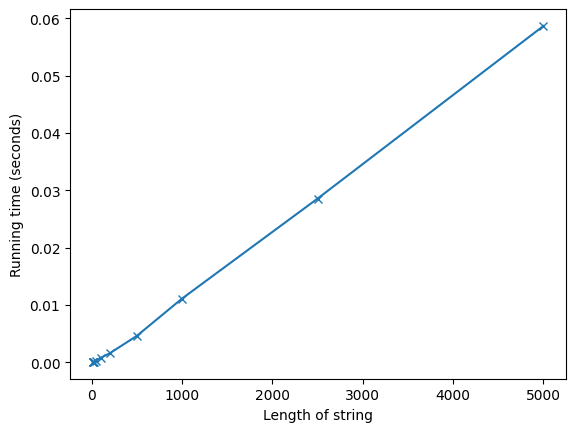

In [89]:
from matplotlib import pyplot as plt
lengths = [10, 15, 20, 25, 50, 100, 200, 500, 1000, 2500, 5000]
times = [generate_random_str_and_time(l) for l in lengths]
plt.plot(lengths, times, '-x')
plt.xlabel('Length of string')
plt.ylabel('Running time (seconds)')
plt.show()

## Applications of Suffix Tries

We already noted a simple application of suffix tries to pattern matching. Given a large string $s$, we can pre-process it to build its suffix trie. 

### Finding occurrences of patterns

When we query the suffix trie with a shorter pattern string $t$, we can rapidly answer the following questions in time proportional to the length of the pattern $t$.
  - Does $t$ appear as a substring in $s$?
  - What is the largest prefix of $t$ that appears as a substring in $s$?
  - How many times does $t$ appear as a substring of $s$?
  - List the starting positions of all occurrences of $t$ in $s$ ? note that this will take time $O(|t| + k)$ where $k$ is the number of occurrences of $t$ in $s$.
  
We can also extend this to patterns with wild-cards which can stand for any character.



In [26]:
def find_all_occurrences(root, pattern):
    addr = TrieAddress(root) # start at the root
    n = len(pattern)
    for i in range(n): # traverse the trie according to the successive characters of the pattern 
        addr = addr.traverse_next(pattern[i])
        if addr == None:
            print(f'{pattern} does not appear in the string. The longest prefix that does occur is {pattern[:i]}')
            return [] # return empty list.
    # if we are here then addr cannot be null
    assert addr != None
    # now collect all the leaves reachable from address and obtain the suffix start position fields from them
    start_positions = []
    list_of_nodes = []
    if addr.edge == None:
        list_of_nodes.append(addr.node)
    else:
        list_of_nodes.append(addr.edge.dest)
    while len(list_of_nodes) > 0:
        # pop a node from the list
        node = list_of_nodes.pop()
        if node.is_leaf(): #if it is a leaf, then append the starting position of the suffix corr. to this leaf
            start_positions.append(node.suffix_start_pos)
        else:
            # else, get all the children node
            for (_, edge) in node.outgoing_edges.items():
                list_of_nodes.append(edge.dest) # add them to the list of unprocessed nodes
    return start_positions # return all the start positions
        

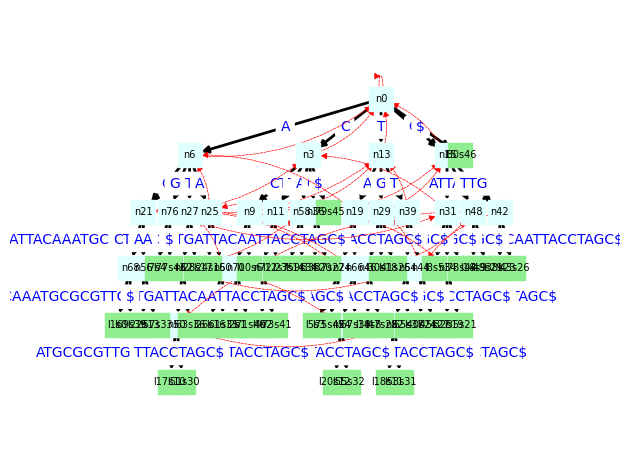

In [27]:
orig_str = "ACCTAGCCTGATTACAAATGCGCGTTGTTGATTACAATTACCTAGC$"
root = construct_suffix_trie(orig_str, debug=False)
draw_networkx_graph(root)
test_suffix_trie(root, orig_str)


In [28]:
find_all_occurrences(root, "GATTACA")

[29, 9]

In [29]:
find_all_occurrences(root, "CAATT")

[34]

In [30]:
find_all_occurrences(root, "ATT")

[36, 30, 10]

In [31]:
find_all_occurrences(root, "AT")

[17, 36, 30, 10]

### Longest Common Substring

Consider two strings $s, t$. We wish to findout the longest string $p$ such that $p$ is a substring of both $s$ and $t$. Note that this is different from the longest common subsequence problem studied earlier in course # 3 on dynamic programming. $p$ must appear in contiguous positions in $s, t$.

For instance, consider $s = banana\$$ and $t = bnanabna\$$.  The longest common substring is "nana".

The idea is to build a suffix trie for the string $s$. Next we traverse the suffix trie according to string $t$ with $i$ starting from $0$ and ranging over the positions of string $t$.

At any step $i$, we maintain the current address which represents the longest suffix of $t[0], \ldots, t[i-1]$ that is a substring of $s$.   For step $i+1$, we try to see if the current address can be extended by $t[i]$. If not, we traverse suffix links until we reach a point where we can extend by $t[i]$. If no such point exists, we reset back to the root node.

As this process continues, we store the deepest point in the suffix trie that was reached so far. This is in fact the longest common substring between $t[0], \ldots, t[i-1]$ and $s$. When the process terminates, we compute this substring and return it.

The algorithm runs in time $O(|s| + |t|)$ if we use the efficient linear time suffix trie construction algorithm.

In [43]:
def find_longest_common_substring(s, t):
    n = len(t)
    root = construct_suffix_trie(s, debug=False)
    addr = TrieAddress(root) # start with the address being the root
    best_depth = 0
    best_addr = addr 
    # go through each index of t
    for i in range(n): 
        c = t[i] 
        addr1 = addr.traverse_next(c) # try to extend current address by c
        while addr1 == None and not addr.is_at_root(): # as long as we keep failing or we are not at the root 
            addr = addr.compute_suffix() # compute the suffix address
            addr1 = addr.traverse_next(c) # see if the suffix can be extended
        if addr1 != None: 
            addr = addr1
        addr_depth = addr.compute_depth()# lookup depth of the current address
        if addr_depth > best_depth: # if it is greater than the best so far
            best_depth = addr_depth # update the best so far
            best_addr = addr 
    
    # now compute the common substring by traversing back from the best address to the root
    common_substring = ""
    if best_addr.edge != None: # if we are in the middle of an edge, append the substring and go to the internal node
        lo_idx = best_addr.edge.lo
        offs = best_addr.offs
        common_substring = s[lo_idx:lo_idx+offs]
    cur_node = best_addr.node
    while cur_node.parent != None: # keep traversing parent pointer until we hit root
        parent_node = cur_node.parent
        parent_edge = parent_node.find_edge_corresponding_to_child(cur_node)
        assert parent_edge != None
        assert not parent_edge.is_leaf_edge()
        # add the relevant substring for each edge we traverse to the common substring
        common_substring = s[parent_edge.lo:parent_edge.hi+1] + common_substring
        cur_node = parent_node 
    return common_substring

In [53]:
find_longest_common_substring("banananaxnanana$", "bnananaxbnanana$")

'nananax'

In [54]:
find_longest_common_substring("TTATTGAGGATTACATT$", "ACTGGATTACATA$")

'GGATTACAT'